# Numerical Benchmarks

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Check Convergence

### Overparameterization

In [2]:
n = 3
d = 2**n
num_reps = 10
num_iter = 4000

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

inputs, _ = generate_pauli_circuits(n = n, 
                                    circuit_target=None, 
                                    N = None, 
                                    trace=False)

rank = 3
loss_values = np.zeros((num_iter, num_reps))
c_values = np.zeros((num_iter, num_reps))


for i in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank)

    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    c = random.uniform(0,1)
    kraus_model = KrausMap(
                       U=U, 
                       c=c, 
                       d=d, 
                       rank=d**2-1
                      )

    model = ModelQuantumMap(
                           q_map = kraus_model,
                           loss = probs_loss,
                           optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs,
                targets = targets,
                inputs_val = None,
                targets_val = [kraus_target],
                num_iter = num_iter,
                N = 500,
                verbose = False,
                )
    
    loss_values[:, i] = np.array(model.loss_list)
    c_values[:, i] = np.array(model.c_list)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [3]:
data = [loss_values, c_values]
pickle.dump(data, open("../../data/compressed_sensing_overparam.p", "wb"))

### Under-parameterization

In [15]:
n = 3
d = 2**n
num_reps = 10
num_iter = 4000

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

inputs, _ = generate_pauli_circuits(n = n, 
                                    circuit_target=None, 
                                    N = None, 
                                    trace=False)

rank = 3
loss_values = np.zeros((num_iter, num_reps))
c_values = np.zeros((num_iter, num_reps))


for i in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank=7)

    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    c = random.uniform(0,1)
    kraus_model = KrausMap(
                       U=U, 
                       c=c, 
                       d=d, 
                       rank=rank
                      )

    model = ModelQuantumMap(
                           q_map = kraus_model,
                           loss = probs_loss,
                           optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           )


    model.train(inputs = inputs,
                targets = targets,
                inputs_val = None,
                targets_val = [kraus_target],
                num_iter = num_iter,
                N = 500,
                verbose = False,
                )
    
    loss_values[:, i] = np.array(model.loss_list)
    c_values[:, i] = np.array(model.c_list)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
data = [loss_values, c_values]
pickle.dump(data, open("../../data/compressed_sensing_underparam.p", "wb"))

## Sparse Input
### Generate Data

In [6]:
np.random.seed(42)
random.seed(42)

N_list = [int(16*2**(i/4)) for i in range(21)]
num_reps = 10

### Low Rank

In [7]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = 3

prior_fidelity = np.zeros((len(N_list), num_reps))
noPrior_fidelity = np.zeros((len(N_list), num_reps))

for rep in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank)
    
    inputs, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    for i, N in enumerate(N_list):
        kraus_model = KrausMap(
                               U=U, 
                               c=0.9, 
                               d=d, 
                               rank=rank,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        prior_fidelity[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

        kraus_model = KrausMap(
    #                           U=U, 
    #                           c=0.9, 
                               d=d, 
                               rank=rank+1,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        noPrior_fidelity[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [8]:
data = [prior_fidelity, noPrior_fidelity]
pickle.dump(data, open("../../data/compressed_sensing_rank4.p", "wb"))

### Medium Rank

In [9]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = 7

prior_fidelity2 = np.zeros((len(N_list), num_reps))
noPrior_fidelity2 = np.zeros((len(N_list), num_reps))

for rep in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank)
    
    inputs, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
    
    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    for i, N in enumerate(N_list):
        kraus_model = KrausMap(
                               U=U, 
                               c=0.9, 
                               d=d, 
                               rank=rank,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        prior_fidelity2[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

        kraus_model = KrausMap(
    #                           U=U, 
    #                           c=0.9, 
                               d=d, 
                               rank=rank+1,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        noPrior_fidelity2[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [10]:
data = [prior_fidelity2, noPrior_fidelity2]
pickle.dump(data, open("../../data/compressed_sensing_rank8.p", "wb"))

### High Rank

In [11]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = 15

prior_fidelity3 = np.zeros((len(N_list), num_reps))
noPrior_fidelity3 = np.zeros((len(N_list), num_reps))

for rep in tqdm(range(num_reps)):
    X, _, _ = generate_ginibre(d, d)
    U = generate_unitary(X) # Random unitary part
    kraus_target = KrausMap(U, 0.5, d, rank)
    
    inputs, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
    
    states = kraus_target.apply_map(inputs[0])
    targets = measurement(states, U_basis = inputs[1])
    
    for i, N in enumerate(N_list):
        kraus_model = KrausMap(
                               U=U, 
                               c=0.9, 
                               d=d, 
                               rank=rank,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        prior_fidelity3[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

        kraus_model = KrausMap(
    #                           U=U, 
    #                           c=0.9, 
                               d=d, 
                               rank=rank+1,
                              )

        model = ModelQuantumMap(
                                q_map = kraus_model,
                                loss = probs_loss,
                                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                )

        model.train(inputs = [inputs[0][:N], inputs[1][:N]],
                    targets = targets[:N],
                    inputs_val = None,
                    targets_val = None,
                    num_iter = 4000,
                    N = N,
                    verbose = False,
                    )

        noPrior_fidelity3[i, rep] = np.abs(channel_fidelity(kraus_target, kraus_model).numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
data = [prior_fidelity3, noPrior_fidelity3]
pickle.dump(data, open("../../data/compressed_sensing_rank16.p", "wb"))

## Collapse of SPAM optimization

In [5]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 2
d = 2**n
rank = d

spam_target = SPAM(d=d, 
                   init = "ideal",
                   povm = "ideal",
                   )

### Generate Synthetic Data

In [6]:
inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)

### Fit SPAM model, no Pre-Training

In [7]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam_model = SPAM(d=d,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 N = N_spam
                 )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.8921902649442504
1 0.8791598613811485
2 0.8664378444021044
3 0.8540343076056153
4 0.8419629923787567
5 0.8302745546766239
6 0.8189254316461283
7 0.8079260217838797
8 0.797328867453269
9 0.7870964791473015
10 0.777252467281691
11 0.7678012329386679
12 0.7587422764817365
13 0.7500702533673002
14 0.7417746797010677
15 0.7338403029673441
16 0.7262488917928419
17 0.7189027999203573
18 0.7119036809497677
19 0.7051607061504508
20 0.698659058733764
21 0.6923715001368348
22 0.686269955117023
23 0.6803124724279446
24 0.6744751479178335
25 0.6685125168635264
26 0.6625511847186242
27 0.6565805147614103
28 0.6505763580483962
29 0.6445173936169589
30 0.6383315697365317
31 0.6320002069949808
32 0.6255589484899267
33 0.6190020285950987
34 0.6123305431961066
35 0.6055321927646852
36 0.5985269314117969
37 0.5914369933423573
38 0.584354221313732
39 0.5772045325834525
40 0.5699881035740305
41 0.5626968709831999
42 0.5553200487824674
43 0.5479018421513429
44 0.5406513321294365
45 0.5333543059059592
46 

348 0.0015876286600823154
349 0.0015708913235540818
350 0.0015543946231788024
351 0.0015381343414898033
352 0.001522106365904954
353 0.0015063066799949558
354 0.0014907313551195392
355 0.0014753765424396434
356 0.001460238465348555
357 0.0014453134123963915
358 0.001430597730811323
359 0.0014160878207449149
360 0.0014017801303755812
361 0.0013876711520023146
362 0.0013737574192336178
363 0.0013600355053461927
364 0.0013465020228343465
365 0.0013331536241198115
366 0.0013199870033330794
367 0.0013069988990203857
368 0.0012941860975886942
369 0.0012815454372639462
370 0.0012690738123173487
371 0.0012567681773128726
372 0.0012446255511396867
373 0.0012326430206174334
374 0.001220817743504387
375 0.0012091469507725275
376 0.001197627948074157
377 0.0011862581163608614
378 0.0011750349116642143
379 0.0011639558640857517
380 0.0011530185760675307
381 0.001142220720039083
382 0.0011315600355436058
383 0.0011210343259504705
384 0.0011106414548597173
385 0.0011003793422912208
386 0.001090245960

666 0.00017268636408901812
667 0.00017183802017576688
668 0.00017099513491612738
669 0.000170157664047628
670 0.00016932556374858848
671 0.00016849879063978522
672 0.00016767730178572472
673 0.0001668610546942527
674 0.0001660500073155265
675 0.0001652441180389652
676 0.00016444334568941544
677 0.00016364764952132111
678 0.0001628569892120496
679 0.0001620713248538926
680 0.00016129061694522038
681 0.00016051482638076699
682 0.0001597439144416271
683 0.00015897784278510034
684 0.00015821657343413953
685 0.0001574600687680136
686 0.00015670829151252685
687 0.00015596120473190575
688 0.00015521877182104966
689 0.00015448095649893564
690 0.00015374772280386058
691 0.0001530190350884746
692 0.0001522948580173824
693 0.00015157515656496725
694 0.00015085989601453504
695 0.00015014904195782854
696 0.00014944256029593512
697 0.00014874041723971485
698 0.00014804257931133342
699 0.00014734901334494848
700 0.00014665968648790175
701 0.00014597456620117665
702 0.0001452936202594229
703 0.0001446

980 4.8334148550515586e-05
981 4.816987429590819e-05
982 4.8006307527217275e-05
983 4.7843444492757436e-05
984 4.768128146479113e-05
985 4.751981473942832e-05
986 4.7359040636313364e-05
987 4.7198955498505205e-05
988 4.7039555692172285e-05
989 4.688083760658388e-05
990 4.672279765360881e-05
991 4.6565432267755674e-05
992 4.640873790585695e-05
993 4.625271104693287e-05
994 4.6097348191959155e-05
995 4.5942645863702894e-05
996 4.578860060668322e-05
997 4.5635208986863736e-05
998 4.5482467591567404e-05
999 4.533037302947756e-05


In [8]:
print(spam_target.init.numpy())
print(spam_model.init.numpy())
print("--------")
print(spam_target.povm.numpy())
print(spam_model.povm.numpy())

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[ 1.965e-03+0.000e+00j -7.086e-04-3.434e-02j -5.023e-05-1.687e-05j
   1.188e-03+1.347e-04j]
 [-7.086e-04+3.434e-02j  9.967e-01+0.000e+00j -8.379e-04-6.996e-04j
   1.668e-03+3.468e-02j]
 [-5.023e-05+1.687e-05j -8.379e-04+6.996e-04j  7.517e-06+0.000e+00j
  -3.293e-05-3.832e-05j]
 [ 1.188e-03-1.347e-04j  1.668e-03-3.468e-02j -3.293e-05+3.832e-05j
   1.284e-03+0.000e+00j]]
--------
[[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0

In [10]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam_model = SPAM(d=d,
                  init = "ideal",
                  povm = "ideal",
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 N = N_spam
                 )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

In [11]:
print(spam_target.init.numpy())
print(spam_model.init.numpy())
print("--------")
print(spam_target.povm.numpy())
print(spam_model.povm.numpy())

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
--------
[[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]]
[[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+

## Recover SPAM and Map

### Generate True Model, Full POVM and Inital

In [12]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n
rank = d
c1 = 0.9
c2 = 0.9

#prep error and full POVM error
spam_target = SPAM(d=d)

init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

spam_target = SPAM(d=d,
                  init = init_target,
                  povm = povm_target)

kraus_target = KrausMap(
                        U=generate_unitary(d=d), 
                        c=0.5, 
                        d=d, 
                        rank=rank-1,
                        spam = spam_target
                        )

### Generate Synthetic Data without Noise

In [13]:
inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)

inputs_map, _ = generate_pauli_circuits(n = n, 
                                    circuit_target=None, 
                                    N = None, 
                                    trace=False)
U_prep, U_basis = inputs_map

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_map(state)
targets_map = measurement(state, U_basis, spam_target.povm)

### Fit Model, No SPAM

In [14]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

model_list = []
for i in range(10):

    kraus_model = KrausMap(
                           d = d, 
                           rank = rank,
                           spam = None,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )

    model.train(inputs = inputs_map,
                targets = targets_map,
                #inputs_val = inputs_map,
                #targets_val = targets_map,
                num_iter = 1000,
                N = 1000,
#                verbose = False,
                )
    
    model_list.append(model)


  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.24955, val: 0.00000
Step:1, train: 0.24173, val: 0.00000
Step:2, train: 0.24238, val: 0.00000
Step:3, train: 0.23989, val: 0.00000
Step:4, train: 0.23749, val: 0.00000
Step:5, train: 0.23868, val: 0.00000
Step:6, train: 0.23293, val: 0.00000
Step:7, train: 0.22704, val: 0.00000
Step:8, train: 0.23182, val: 0.00000
Step:9, train: 0.21883, val: 0.00000
Step:10, train: 0.22197, val: 0.00000
Step:11, train: 0.21541, val: 0.00000
Step:12, train: 0.21620, val: 0.00000
Step:13, train: 0.21189, val: 0.00000
Step:14, train: 0.20426, val: 0.00000
Step:15, train: 0.20836, val: 0.00000
Step:16, train: 0.20644, val: 0.00000
Step:17, train: 0.19890, val: 0.00000
Step:18, train: 0.19203, val: 0.00000
Step:19, train: 0.19449, val: 0.00000
Step:20, train: 0.19021, val: 0.00000
Step:21, train: 0.18869, val: 0.00000
Step:22, train: 0.18927, val: 0.00000
Step:23, train: 0.18030, val: 0.00000
Step:24, train: 0.18476, val: 0.00000
Step:25, train: 0.18185, val: 0.00000
Step:26, train: 0.1760

Step:214, train: 0.02071, val: 0.00000
Step:215, train: 0.02064, val: 0.00000
Step:216, train: 0.02093, val: 0.00000
Step:217, train: 0.02052, val: 0.00000
Step:218, train: 0.02047, val: 0.00000
Step:219, train: 0.02087, val: 0.00000
Step:220, train: 0.02099, val: 0.00000
Step:221, train: 0.02057, val: 0.00000
Step:222, train: 0.02061, val: 0.00000
Step:223, train: 0.02026, val: 0.00000
Step:224, train: 0.02063, val: 0.00000
Step:225, train: 0.01999, val: 0.00000
Step:226, train: 0.02030, val: 0.00000
Step:227, train: 0.01994, val: 0.00000
Step:228, train: 0.01955, val: 0.00000
Step:229, train: 0.01972, val: 0.00000
Step:230, train: 0.01940, val: 0.00000
Step:231, train: 0.01936, val: 0.00000
Step:232, train: 0.02031, val: 0.00000
Step:233, train: 0.01959, val: 0.00000
Step:234, train: 0.01954, val: 0.00000
Step:235, train: 0.01985, val: 0.00000
Step:236, train: 0.01904, val: 0.00000
Step:237, train: 0.01949, val: 0.00000
Step:238, train: 0.01889, val: 0.00000
Step:239, train: 0.01922,

Step:425, train: 0.01073, val: 0.00000
Step:426, train: 0.01071, val: 0.00000
Step:427, train: 0.01066, val: 0.00000
Step:428, train: 0.01033, val: 0.00000
Step:429, train: 0.01048, val: 0.00000
Step:430, train: 0.01026, val: 0.00000
Step:431, train: 0.01037, val: 0.00000
Step:432, train: 0.01047, val: 0.00000
Step:433, train: 0.01015, val: 0.00000
Step:434, train: 0.01016, val: 0.00000
Step:435, train: 0.01017, val: 0.00000
Step:436, train: 0.00978, val: 0.00000
Step:437, train: 0.01009, val: 0.00000
Step:438, train: 0.01000, val: 0.00000
Step:439, train: 0.01022, val: 0.00000
Step:440, train: 0.00996, val: 0.00000
Step:441, train: 0.00990, val: 0.00000
Step:442, train: 0.00994, val: 0.00000
Step:443, train: 0.00998, val: 0.00000
Step:444, train: 0.00962, val: 0.00000
Step:445, train: 0.00962, val: 0.00000
Step:446, train: 0.00983, val: 0.00000
Step:447, train: 0.00983, val: 0.00000
Step:448, train: 0.00981, val: 0.00000
Step:449, train: 0.00941, val: 0.00000
Step:450, train: 0.00976,

Step:637, train: 0.00579, val: 0.00000
Step:638, train: 0.00577, val: 0.00000
Step:639, train: 0.00568, val: 0.00000
Step:640, train: 0.00560, val: 0.00000
Step:641, train: 0.00568, val: 0.00000
Step:642, train: 0.00571, val: 0.00000
Step:643, train: 0.00565, val: 0.00000
Step:644, train: 0.00571, val: 0.00000
Step:645, train: 0.00587, val: 0.00000
Step:646, train: 0.00561, val: 0.00000
Step:647, train: 0.00571, val: 0.00000
Step:648, train: 0.00572, val: 0.00000
Step:649, train: 0.00570, val: 0.00000
Step:650, train: 0.00575, val: 0.00000
Step:651, train: 0.00566, val: 0.00000
Step:652, train: 0.00554, val: 0.00000
Step:653, train: 0.00555, val: 0.00000
Step:654, train: 0.00558, val: 0.00000
Step:655, train: 0.00576, val: 0.00000
Step:656, train: 0.00556, val: 0.00000
Step:657, train: 0.00547, val: 0.00000
Step:658, train: 0.00550, val: 0.00000
Step:659, train: 0.00554, val: 0.00000
Step:660, train: 0.00558, val: 0.00000
Step:661, train: 0.00545, val: 0.00000
Step:662, train: 0.00544,

Step:849, train: 0.00353, val: 0.00000
Step:850, train: 0.00352, val: 0.00000
Step:851, train: 0.00351, val: 0.00000
Step:852, train: 0.00355, val: 0.00000
Step:853, train: 0.00348, val: 0.00000
Step:854, train: 0.00352, val: 0.00000
Step:855, train: 0.00349, val: 0.00000
Step:856, train: 0.00350, val: 0.00000
Step:857, train: 0.00353, val: 0.00000
Step:858, train: 0.00339, val: 0.00000
Step:859, train: 0.00340, val: 0.00000
Step:860, train: 0.00343, val: 0.00000
Step:861, train: 0.00332, val: 0.00000
Step:862, train: 0.00348, val: 0.00000
Step:863, train: 0.00332, val: 0.00000
Step:864, train: 0.00345, val: 0.00000
Step:865, train: 0.00336, val: 0.00000
Step:866, train: 0.00336, val: 0.00000
Step:867, train: 0.00337, val: 0.00000
Step:868, train: 0.00345, val: 0.00000
Step:869, train: 0.00338, val: 0.00000
Step:870, train: 0.00340, val: 0.00000
Step:871, train: 0.00335, val: 0.00000
Step:872, train: 0.00335, val: 0.00000
Step:873, train: 0.00337, val: 0.00000
Step:874, train: 0.00332,

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.25948, val: 0.00000
Step:1, train: 0.25164, val: 0.00000
Step:2, train: 0.25089, val: 0.00000
Step:3, train: 0.25746, val: 0.00000
Step:4, train: 0.23866, val: 0.00000
Step:5, train: 0.23821, val: 0.00000
Step:6, train: 0.23514, val: 0.00000
Step:7, train: 0.23293, val: 0.00000
Step:8, train: 0.23055, val: 0.00000
Step:9, train: 0.22774, val: 0.00000
Step:10, train: 0.22394, val: 0.00000
Step:11, train: 0.21436, val: 0.00000
Step:12, train: 0.22057, val: 0.00000
Step:13, train: 0.21632, val: 0.00000
Step:14, train: 0.21896, val: 0.00000
Step:15, train: 0.20485, val: 0.00000
Step:16, train: 0.19733, val: 0.00000
Step:17, train: 0.20648, val: 0.00000
Step:18, train: 0.19997, val: 0.00000
Step:19, train: 0.19777, val: 0.00000
Step:20, train: 0.19681, val: 0.00000
Step:21, train: 0.19763, val: 0.00000
Step:22, train: 0.18852, val: 0.00000
Step:23, train: 0.18694, val: 0.00000
Step:24, train: 0.18742, val: 0.00000
Step:25, train: 0.18842, val: 0.00000
Step:26, train: 0.1795

KeyboardInterrupt: 

In [15]:
channel_fidelity(model_list[0].q_map, kraus_target).numpy()

0.9779861346066492

### Fit Model, Full Initial and POVM

In [18]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

model_list = []

for i in range(10):
    spam_model = SPAM(d=d,
    #                  use_corr_mat=True,
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))

    spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                        num_iter = 1000,
                        )

    spam_model.train(inputs = inputs_spam,
                     targets = targets_spam,
                     num_iter = 1000,
                     N = N_spam
                    )

    kraus_model = KrausMap(
                           d = d, 
                           rank = rank,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )

    model.train(inputs = inputs_map,
                targets = targets_map,
                #inputs_val = inputs_map,
                #targets_val = targets_map,
                num_iter = 1000,
                N = 1000
                )
    
    model_list.append(model)

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.029998712430644576
1 0.029729522666170256
2 0.029456741481652206
3 0.029180939493493506
4 0.028902392267767252
5 0.028621073053286455
6 0.028336895670729837
7 0.02804997658594075
8 0.027760402003156506
9 0.02746820378024727
10 0.027173380640739375
11 0.026875825048475424
12 0.02657474743964164
13 0.026270537034930416
14 0.025963232065738272
15 0.025652615052742855
16 0.02533843599571127
17 0.025021085338515183
18 0.0247005990779781
19 0.02437688780422411
20 0.024050330112198728
21 0.02372033511291493
22 0.023387124416308212
23 0.02305111483465782
24 0.02271206651101845
25 0.022370407966489606
26 0.022025855878022835
27 0.02167896482772349
28 0.02132966054415427
29 0.0209769395836445
30 0.020621135859645125
31 0.020262630321310773
32 0.019902154432159442
33 0.019538735056069997
34 0.019173698059067264
35 0.01880629611806011
36 0.018437008499375303
37 0.018065850844988074
38 0.017693473050885256
39 0.01731968169788978
40 0.016945261355020634
41 0.016570150476158174
42 0.0161951606164

326 4.9342595408071536e-05
327 4.8907903170157e-05
328 4.8478360135873494e-05
329 4.805385225071592e-05
330 4.7634306835952945e-05
331 4.721975734450423e-05
332 4.6810044702411146e-05
333 4.640509983316272e-05
334 4.600479227463475e-05
335 4.560913468629194e-05
336 4.5218069564398715e-05
337 4.483153525533549e-05
338 4.444946471468021e-05
339 4.407178723409717e-05
340 4.3698463945911996e-05
341 4.332941761174989e-05
342 4.2964582575161144e-05
343 4.260389199617994e-05
344 4.2247279420479116e-05
345 4.1894680117906345e-05
346 4.154603141937472e-05
347 4.1201271970988e-05
348 4.086034055174904e-05
349 4.052317540800828e-05
350 4.018966433057729e-05
351 3.9859800525645134e-05
352 3.9533525390915604e-05
353 3.921078567765826e-05
354 3.88915343774185e-05
355 3.857572980165619e-05
356 3.8263364705005124e-05
357 3.795437264135092e-05
358 3.764871569634438e-05
359 3.734635352903995e-05
360 3.704724451554197e-05
361 3.675134697038698e-05
362 3.6458619583809025e-05
363 3.616902093765089e-05
364 

640 6.826726012532994e-06
641 6.794671165410916e-06
642 6.762811340927492e-06
643 6.731144191047194e-06
644 6.69966845483371e-06
645 6.668382787183699e-06
646 6.637285760930453e-06
647 6.606375953484062e-06
648 6.5756507683933195e-06
649 6.54511025618084e-06
650 6.514753077733715e-06
651 6.4845787476488855e-06
652 6.454584957646056e-06
653 6.424770367563658e-06
654 6.395133621550542e-06
655 6.3656733558476436e-06
656 6.336388213510799e-06
657 6.307275683631369e-06
658 6.2783356818327865e-06
659 6.249566859996781e-06
660 6.2209678827225974e-06
661 6.19253827911995e-06
662 6.164276108400525e-06
663 6.136180274496325e-06
664 6.108249660607762e-06
665 6.080483116878257e-06
666 6.05287946258945e-06
667 6.025437491282428e-06
668 5.998154847401309e-06
669 5.971031494344762e-06
670 5.944066158812171e-06
671 5.917257621330938e-06
672 5.8906055261262205e-06
673 5.864108101946368e-06
674 5.837764318066241e-06
675 5.811573085479613e-06
676 5.7855332942290654e-06
677 5.7596428043271865e-06
678 5.73

959 1.9521224475315167e-06
960 1.9456461229466994e-06
961 1.9391967270710153e-06
962 1.932774350594077e-06
963 1.9263788074623718e-06
964 1.92001000632609e-06
965 1.9136677469826684e-06
966 1.9073519358153475e-06
967 1.9010624529649563e-06
968 1.8947989627964044e-06
969 1.8885615408658714e-06
970 1.8823501501739376e-06
971 1.8761645147271934e-06
972 1.8700045029023462e-06
973 1.8638698130397074e-06
974 1.8577604998043433e-06
975 1.8516765403217461e-06
976 1.8456177150774052e-06
977 1.8395839092497637e-06
978 1.8335748185102923e-06
979 1.8275905017748973e-06
980 1.821630914489727e-06
981 1.815695813190293e-06
982 1.8097850800816287e-06
983 1.8038984278391607e-06
984 1.7980360453762632e-06
985 1.7921975179468344e-06
986 1.7863830063634065e-06
987 1.780592269533842e-06
988 1.7748250364672023e-06
989 1.7690813528324702e-06
990 1.7633611807139807e-06
991 1.7576643128413035e-06
992 1.7519906406971482e-06
993 1.7463400477333893e-06
994 1.7407122407845408e-06
995 1.7351072876352088e-06
996 1.7

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.04412337131286748
1 0.04301584539257563
2 0.041804463167660226
3 0.04018542654043334
4 0.03814113500958635
5 0.035748595636476976
6 0.03301556268110087
7 0.030031716469778133
8 0.02695170518617785
9 0.023973184694773355
10 0.021340071417717984
11 0.01920688585360517
12 0.017605659592721243
13 0.01638336838500387
14 0.015278581253275945
15 0.014076044269044971
16 0.012738071988936247
17 0.011401097245547815
18 0.010195885726521173
19 0.009116440195606892
20 0.00822563374690314
21 0.007500495794069434
22 0.006877994191618913
23 0.006328598377299287
24 0.0058327556207665885
25 0.005363618257834419
26 0.004908625272825564
27 0.004470726987014871
28 0.004066385207399282
29 0.0037133979138690596
30 0.003405008791783553
31 0.0031340654603966528
32 0.0028842282263948993
33 0.0026624421922102986
34 0.002468165765157904
35 0.0023009241015821942
36 0.0021548181227496474
37 0.002024332695143708
38 0.0019009984818480772
39 0.001791332060747886
40 0.0016936896753487905
41 0.0016057831232077218
4

318 1.9830781520466728e-05
319 1.9677378270483453e-05
320 1.9525610231406337e-05
321 1.9375369631210954e-05
322 1.9226590841697032e-05
323 1.9079287205991792e-05
324 1.893342917731054e-05
325 1.8788973799385903e-05
326 1.864597083816263e-05
327 1.850447218588361e-05
328 1.8364413009493642e-05
329 1.8225709009887895e-05
330 1.8088357097225583e-05
331 1.795235411186336e-05
332 1.781765825900013e-05
333 1.768428210994445e-05
334 1.7552277356771973e-05
335 1.7421615645388806e-05
336 1.729221624486529e-05
337 1.7164056621898868e-05
338 1.703714248223979e-05
339 1.691144382231758e-05
340 1.6786953545271505e-05
341 1.6663713061718693e-05
342 1.6541718356875632e-05
343 1.6420902671817724e-05
344 1.6301230852489843e-05
345 1.6182708206287965e-05
346 1.606531746130839e-05
347 1.5949043764154145e-05
348 1.5833913279128625e-05
349 1.571993029369716e-05
350 1.5607041913462594e-05
351 1.5495208508107766e-05
352 1.5384430921251214e-05
353 1.5274699398322328e-05
354 1.5165999032805106e-05
355 1.505834

633 3.4711674373777486e-06
634 3.4576777608237787e-06
635 3.4442612015061115e-06
636 3.4309178330094434e-06
637 3.4176472337101895e-06
638 3.404448220364168e-06
639 3.391319332149041e-06
640 3.378259940316073e-06
641 3.3652701725721487e-06
642 3.3523500660420143e-06
643 3.3394991286074977e-06
644 3.3267161305928753e-06
645 3.3139997424235928e-06
646 3.3013495289301626e-06
647 3.288765661292127e-06
648 3.276248127805303e-06
649 3.263796349668133e-06
650 3.251409060576478e-06
651 3.239085094608842e-06
652 3.22682420463588e-06
653 3.2146265823221277e-06
654 3.2024921528187316e-06
655 3.1904202353006186e-06
656 3.1784095497255194e-06
657 3.166459127991821e-06
658 3.1545688938319058e-06
659 3.1427390340317103e-06
660 3.130969394381176e-06
661 3.1192591812196822e-06
662 3.107607139077971e-06
663 3.096012527489594e-06
664 3.084475411303325e-06
665 3.0729959466808336e-06
666 3.0615738809636175e-06
667 3.050208306091399e-06
668 3.0388980438671805e-06
669 3.0276425984182883e-06
670 3.01644213443

941 1.1978111926157078e-06
942 1.1939338968609845e-06
943 1.1900702591820022e-06
944 1.1862206534115492e-06
945 1.182385163780105e-06
946 1.178563165949516e-06
947 1.1747542622031639e-06
948 1.1709587686361904e-06
949 1.1671770661374307e-06
950 1.1634092511004536e-06
951 1.1596546876126163e-06
952 1.1559129717063104e-06
953 1.1521844288008116e-06
954 1.148469446024486e-06
955 1.1447681254453097e-06
956 1.1410798126609798e-06
957 1.1374041070654872e-06
958 1.1337413479067613e-06
959 1.1300919279256262e-06
960 1.1264559478189175e-06
961 1.122832727439424e-06
962 1.119221880365405e-06
963 1.1156237636608247e-06
964 1.1120387752516677e-06
965 1.1084670064105e-06
966 1.1049077442183767e-06
967 1.1013606287890246e-06
968 1.0978260379990277e-06
969 1.0943043747807004e-06
970 1.0907957113737076e-06
971 1.0872992960666593e-06
972 1.0838148095642272e-06
973 1.0803426520801094e-06
974 1.0768832316869931e-06
975 1.0734365897894587e-06
976 1.0700019319410966e-06
977 1.066578995112971e-06
978 1.0631

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.21821, val: 0.00000
Step:1, train: 0.22258, val: 0.00000
Step:2, train: 0.21376, val: 0.00000
Step:3, train: 0.20980, val: 0.00000
Step:4, train: 0.20983, val: 0.00000
Step:5, train: 0.20974, val: 0.00000
Step:6, train: 0.20770, val: 0.00000
Step:7, train: 0.20583, val: 0.00000
Step:8, train: 0.19576, val: 0.00000
Step:9, train: 0.19945, val: 0.00000
Step:10, train: 0.19982, val: 0.00000
Step:11, train: 0.19809, val: 0.00000
Step:12, train: 0.19370, val: 0.00000
Step:13, train: 0.18087, val: 0.00000
Step:14, train: 0.18303, val: 0.00000
Step:15, train: 0.18303, val: 0.00000
Step:16, train: 0.17975, val: 0.00000
Step:17, train: 0.17912, val: 0.00000
Step:18, train: 0.17781, val: 0.00000
Step:19, train: 0.18022, val: 0.00000
Step:20, train: 0.17435, val: 0.00000
Step:21, train: 0.17109, val: 0.00000
Step:22, train: 0.16734, val: 0.00000
Step:23, train: 0.16956, val: 0.00000
Step:24, train: 0.16010, val: 0.00000
Step:25, train: 0.16158, val: 0.00000
Step:26, train: 0.1619

Step:214, train: 0.01173, val: 0.00000
Step:215, train: 0.01270, val: 0.00000
Step:216, train: 0.01272, val: 0.00000
Step:217, train: 0.01257, val: 0.00000
Step:218, train: 0.01197, val: 0.00000
Step:219, train: 0.01212, val: 0.00000
Step:220, train: 0.01202, val: 0.00000
Step:221, train: 0.01213, val: 0.00000
Step:222, train: 0.01203, val: 0.00000
Step:223, train: 0.01194, val: 0.00000
Step:224, train: 0.01189, val: 0.00000
Step:225, train: 0.01185, val: 0.00000
Step:226, train: 0.01203, val: 0.00000
Step:227, train: 0.01143, val: 0.00000
Step:228, train: 0.01184, val: 0.00000
Step:229, train: 0.01164, val: 0.00000
Step:230, train: 0.01143, val: 0.00000
Step:231, train: 0.01124, val: 0.00000
Step:232, train: 0.01148, val: 0.00000
Step:233, train: 0.01098, val: 0.00000
Step:234, train: 0.01135, val: 0.00000
Step:235, train: 0.01150, val: 0.00000
Step:236, train: 0.01128, val: 0.00000
Step:237, train: 0.01089, val: 0.00000
Step:238, train: 0.01098, val: 0.00000
Step:239, train: 0.01126,

Step:426, train: 0.00531, val: 0.00000
Step:427, train: 0.00524, val: 0.00000
Step:428, train: 0.00519, val: 0.00000
Step:429, train: 0.00526, val: 0.00000
Step:430, train: 0.00529, val: 0.00000
Step:431, train: 0.00506, val: 0.00000
Step:432, train: 0.00524, val: 0.00000
Step:433, train: 0.00516, val: 0.00000
Step:434, train: 0.00507, val: 0.00000
Step:435, train: 0.00511, val: 0.00000
Step:436, train: 0.00499, val: 0.00000
Step:437, train: 0.00508, val: 0.00000
Step:438, train: 0.00506, val: 0.00000
Step:439, train: 0.00498, val: 0.00000
Step:440, train: 0.00496, val: 0.00000
Step:441, train: 0.00503, val: 0.00000
Step:442, train: 0.00499, val: 0.00000
Step:443, train: 0.00499, val: 0.00000
Step:444, train: 0.00478, val: 0.00000
Step:445, train: 0.00497, val: 0.00000
Step:446, train: 0.00497, val: 0.00000
Step:447, train: 0.00488, val: 0.00000
Step:448, train: 0.00474, val: 0.00000
Step:449, train: 0.00490, val: 0.00000
Step:450, train: 0.00478, val: 0.00000
Step:451, train: 0.00471,

Step:638, train: 0.00158, val: 0.00000
Step:639, train: 0.00150, val: 0.00000
Step:640, train: 0.00150, val: 0.00000
Step:641, train: 0.00149, val: 0.00000
Step:642, train: 0.00151, val: 0.00000
Step:643, train: 0.00152, val: 0.00000
Step:644, train: 0.00148, val: 0.00000
Step:645, train: 0.00145, val: 0.00000
Step:646, train: 0.00148, val: 0.00000
Step:647, train: 0.00147, val: 0.00000
Step:648, train: 0.00149, val: 0.00000
Step:649, train: 0.00146, val: 0.00000
Step:650, train: 0.00147, val: 0.00000
Step:651, train: 0.00140, val: 0.00000
Step:652, train: 0.00145, val: 0.00000
Step:653, train: 0.00141, val: 0.00000
Step:654, train: 0.00137, val: 0.00000
Step:655, train: 0.00139, val: 0.00000
Step:656, train: 0.00139, val: 0.00000
Step:657, train: 0.00135, val: 0.00000
Step:658, train: 0.00136, val: 0.00000
Step:659, train: 0.00139, val: 0.00000
Step:660, train: 0.00133, val: 0.00000
Step:661, train: 0.00133, val: 0.00000
Step:662, train: 0.00135, val: 0.00000
Step:663, train: 0.00132,

Step:850, train: 0.00037, val: 0.00000
Step:851, train: 0.00035, val: 0.00000
Step:852, train: 0.00037, val: 0.00000
Step:853, train: 0.00037, val: 0.00000
Step:854, train: 0.00035, val: 0.00000
Step:855, train: 0.00036, val: 0.00000
Step:856, train: 0.00036, val: 0.00000
Step:857, train: 0.00035, val: 0.00000
Step:858, train: 0.00034, val: 0.00000
Step:859, train: 0.00034, val: 0.00000
Step:860, train: 0.00034, val: 0.00000
Step:861, train: 0.00034, val: 0.00000
Step:862, train: 0.00034, val: 0.00000
Step:863, train: 0.00034, val: 0.00000
Step:864, train: 0.00032, val: 0.00000
Step:865, train: 0.00034, val: 0.00000
Step:866, train: 0.00032, val: 0.00000
Step:867, train: 0.00032, val: 0.00000
Step:868, train: 0.00032, val: 0.00000
Step:869, train: 0.00031, val: 0.00000
Step:870, train: 0.00032, val: 0.00000
Step:871, train: 0.00032, val: 0.00000
Step:872, train: 0.00030, val: 0.00000
Step:873, train: 0.00032, val: 0.00000
Step:874, train: 0.00032, val: 0.00000
Step:875, train: 0.00031,

In [19]:
channel_fidelity(model_list[0].q_map, kraus_target).numpy()

0.996885806666392

### Fit Model, Initial and Corruption Matrix

In [24]:
np.random.seed(45)
random.seed(45)
tf.random.set_seed(45)

for i in range(10):
    spam_model = SPAM(d=d,
                      use_corr_mat=True,
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))

    spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                        num_iter = 1000,
                        )

    spam_model.train(inputs = inputs_spam,
                     targets = targets_spam,
                     num_iter = 1000,
                     N = N_spam
                    )




    kraus_model = KrausMap(
                           d = d, 
                           rank = rank,
                           spam = spam_model,
                           )

    model = ModelQuantumMap(
                            q_map = kraus_model,
                            loss = probs_loss,
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            )

    model.train(inputs = inputs_map,
                targets = targets_map,
                #inputs_val = inputs_map,
                #targets_val = targets_map,
                num_iter = 1000,
                N = 1000
                )
    
    model.append(model)

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.030847143338659015
1 0.030662459515911837
2 0.030478113635720658
3 0.030294378560601604
4 0.03011125446539551
5 0.0299286394951683
6 0.02974637630255854
7 0.029564343058466922
8 0.029382166271182886
9 0.029199761531843116
10 0.029017001016869184
11 0.028834124534501303
12 0.028650785940328858
13 0.028466479769947366
14 0.028281007779332172
15 0.02809361896369352
16 0.027905004486438477
17 0.027714040522829386
18 0.027520756143509136
19 0.027325171289391166
20 0.02712710205235179
21 0.02692724941940549
22 0.02672547779844971
23 0.026520626423110247
24 0.026311699381119276
25 0.026099274888549243
26 0.025883769335170993
27 0.025665682273699086
28 0.02544524040096212
29 0.025222609140702103
30 0.024996647170454134
31 0.024767377827047465
32 0.02453436545109277
33 0.024298003404903394
34 0.024058226701104274
35 0.023815564230044564
36 0.02356915406288541
37 0.023319200323779987
38 0.02306544890680265
39 0.022809350387594865
40 0.022550724877813944
41 0.022290167802329452
42 0.022026576

331 3.6511596261629186e-05
332 3.618657138621934e-05
333 3.5865092004874195e-05
334 3.554710002206558e-05
335 3.523259201050358e-05
336 3.492157428992078e-05
337 3.461406243846226e-05
338 3.431007868772293e-05
339 3.40096365743444e-05
340 3.371275055427515e-05
341 3.341941368945111e-05
342 3.312958760193579e-05
343 3.284322786155081e-05
344 3.256027993065162e-05
345 3.2280679313774234e-05
346 3.2004357287621025e-05
347 3.173124784660386e-05
348 3.146128804622312e-05
349 3.119440988846168e-05
350 3.093055106659208e-05
351 3.06696514514125e-05
352 3.0411660445555467e-05
353 3.0156524752494703e-05
354 2.9904201138563216e-05
355 2.9654650381537954e-05
356 2.94078432582295e-05
357 2.916375178709954e-05
358 2.8922351681273416e-05
359 2.8683619722250747e-05
360 2.844752731719148e-05
361 2.8214044712288655e-05
362 2.798314104155141e-05
363 2.775477967594176e-05
364 2.7528921813867278e-05
365 2.7305525918907145e-05
366 2.708454976554745e-05
367 2.6865951416733643e-05
368 2.664968946662165e-05
3

643 4.952536888614449e-06
644 4.928943245406903e-06
645 4.9054940436880885e-06
646 4.8821881326770954e-06
647 4.859024380256441e-06
648 4.836001674915553e-06
649 4.813118927080195e-06
650 4.790375069785903e-06
651 4.7677690586835265e-06
652 4.745299871408363e-06
653 4.722966506364772e-06
654 4.7007679810144976e-06
655 4.678703329774621e-06
656 4.6567716016469145e-06
657 4.634971857709996e-06
658 4.61330316860637e-06
659 4.591764612150547e-06
660 4.570355271171402e-06
661 4.54907423168667e-06
662 4.527920581481385e-06
663 4.506893409139213e-06
664 4.4859918035468605e-06
665 4.465214853866859e-06
666 4.444561649942291e-06
667 4.424031283084067e-06
668 4.403622847159602e-06
669 4.38333543990124e-06
670 4.363168164333473e-06
671 4.343120130222465e-06
672 4.3231904554524225e-06
673 4.3033782672445005e-06
674 4.283682703144606e-06
675 4.26410291172888e-06
676 4.244638052991568e-06
677 4.2252872984058985e-06
678 4.2060498306661835e-06
679 4.186924843142382e-06
680 4.1679115390936005e-06
681 4

963 1.4024420753011894e-06
964 1.3978124133551872e-06
965 1.3932020907772523e-06
966 1.3886110009957175e-06
967 1.38403903859182e-06
968 1.3794860996504376e-06
969 1.3749520820619338e-06
970 1.370436885752916e-06
971 1.3659404128347675e-06
972 1.3614625676577853e-06
973 1.3570032567705427e-06
974 1.352562388784008e-06
975 1.348139874152169e-06
976 1.3437356248805604e-06
977 1.3393495541853374e-06
978 1.3349815761217576e-06
979 1.3306316052082805e-06
980 1.3262995560699416e-06
981 1.321985343124364e-06
982 1.317688880328323e-06
983 1.3134100810013127e-06
984 1.3091488577342158e-06
985 1.3049051223869263e-06
986 1.3006787861713385e-06
987 1.2964697598092613e-06
988 1.2922779537532967e-06
989 1.288103278449292e-06
990 1.2839456446217356e-06
991 1.279804963558158e-06
992 1.2756811473731555e-06
993 1.2715741092316623e-06
994 1.2674837635177417e-06
995 1.263410025937082e-06
996 1.2593528135501987e-06
997 1.255312044735514e-06
998 1.2512876390894938e-06
999 1.2472795172747822e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.0486663091753841
1 0.03168023826489982
2 0.019504564380452453
3 0.011273617336848618
4 0.006207914203374642
5 0.00354319665094654
6 0.002582310435824
7 0.002727664497930892
8 0.0034857233016924337
9 0.0044622274492777895
10 0.005386297724415152
11 0.00608482343180194
12 0.006472080737743927
13 0.006535112206720451
14 0.006304099537077818
15 0.005831008129884648
16 0.005177293620399327
17 0.004418358446959548
18 0.0036348050279890166
19 0.0029009953558580387
20 0.0022754367116044646
21 0.0017965620686357046
22 0.0014809100390224322
23 0.0013247125623587392
24 0.001307224983047138
25 0.0013951626563130923
26 0.0015479397028723984
27 0.0017233175861425176
28 0.0018828789975724417
29 0.0019964330574812187
30 0.0020448895974622323
31 0.002021722812549963
32 0.0019329129291414846
33 0.0017949146127137026
34 0.001630682179454969
35 0.0014646815310597919
36 0.0013178327226446044
37 0.0012103009796683845
38 0.0011475527486471534
39 0.0011210188338210937
40 0.0011253529937292378
41 0.0011508

332 0.0005182497384256038
333 0.0005173239581388414
334 0.000519977591871972
335 0.0005208917974458759
336 0.0005188643790160608
337 0.0005178875060719121
338 0.0005188915004490079
339 0.0005190235134802428
340 0.000518212752412644
341 0.0005174739529169238
342 0.0005174028757809841
343 0.0005170265063106388
344 0.0005153487033543396
345 0.0005154282142391849
346 0.0005159092339390973
347 0.0005150161475124844
348 0.0005137454296221644
349 0.0005131617676744285
350 0.0005135486547197089
351 0.0005137639224246561
352 0.0005128902531672414
353 0.0005116869711037829
354 0.0005121510654464896
355 0.0005134213687379415
356 0.0005132637482269625
357 0.0005119801667917464
358 0.0005121159126689341
359 0.0005134272639654827
360 0.0005134174959355758
361 0.000512561404701728
362 0.0005129756685537881
363 0.0005137708001347795
364 0.000513550353438648
365 0.0005135830971908746
366 0.0005143606924748538
367 0.0005143063857372627
368 0.0005140163816544686
369 0.000515045625126635
370 0.00051590666

649 0.0005624183965100226
650 0.000560199664928812
651 0.0005613029485392595
652 0.0005651690460283924
653 0.0005701543646899899
654 0.0005744066931627151
655 0.0005767151234554278
656 0.0005770282792003612
657 0.0005763141924469662
658 0.0005759121869275469
659 0.0005762251813092492
660 0.0005785553513117928
661 0.0005825980055173526
662 0.0005871981292645414
663 0.0005910283547347869
664 0.000593283789850963
665 0.0005939696476658241
666 0.000593794757567864
667 0.0005938325507627604
668 0.0005950603155310049
669 0.0005979129036017728
670 0.0006020950396654135
671 0.0006067414491170592
672 0.0006109462211772996
673 0.0006137696711857517
674 0.000614713982335748
675 0.0006150211569997225
676 0.0006160525919635418
677 0.0006186975703210089
678 0.0006232753407894362
679 0.0006290146018781031
680 0.0006348387903365449
681 0.0006395861582386879
682 0.0006424528508101691
683 0.0006442904079585353
684 0.0006461253714466533
685 0.0006491630725226938
686 0.0006540162000750797
687 0.0006605141

974 0.0005092108849754087
975 0.0005089366506710823
976 0.0005091301082830235
977 0.0005101279163463063
978 0.0005115623415721594
979 0.0005126511119007242
980 0.0005129016348308432
981 0.0005126602446861897
982 0.0005127812405586893
983 0.0005137358639225228
984 0.0005152763409957189
985 0.0005166373170454644
986 0.000517203647104355
987 0.000517260172966732
988 0.0005176927026884304
989 0.000518915400419281
990 0.0005207012592836855
991 0.0005223596286732259
992 0.0005232576731271896
993 0.0005237453967918102
994 0.0005247689194585828
995 0.00052625638940628
996 0.0005281140985024366
997 0.0005298920058452345
998 0.0005310033460851161
999 0.0005320751351520615


  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.21669, val: 0.00000
Step:1, train: 0.21973, val: 0.00000
Step:2, train: 0.21995, val: 0.00000
Step:3, train: 0.21192, val: 0.00000
Step:4, train: 0.20785, val: 0.00000
Step:5, train: 0.20720, val: 0.00000
Step:6, train: 0.20829, val: 0.00000
Step:7, train: 0.20108, val: 0.00000
Step:8, train: 0.20012, val: 0.00000
Step:9, train: 0.19640, val: 0.00000
Step:10, train: 0.19646, val: 0.00000
Step:11, train: 0.19878, val: 0.00000
Step:12, train: 0.18694, val: 0.00000
Step:13, train: 0.18159, val: 0.00000
Step:14, train: 0.18705, val: 0.00000
Step:15, train: 0.18530, val: 0.00000
Step:16, train: 0.18412, val: 0.00000
Step:17, train: 0.17866, val: 0.00000
Step:18, train: 0.17230, val: 0.00000
Step:19, train: 0.17398, val: 0.00000
Step:20, train: 0.17152, val: 0.00000
Step:21, train: 0.17282, val: 0.00000
Step:22, train: 0.16870, val: 0.00000
Step:23, train: 0.17115, val: 0.00000
Step:24, train: 0.16891, val: 0.00000
Step:25, train: 0.16212, val: 0.00000
Step:26, train: 0.1682

Step:217, train: 0.01194, val: 0.00000
Step:218, train: 0.01150, val: 0.00000
Step:219, train: 0.01168, val: 0.00000
Step:220, train: 0.01165, val: 0.00000
Step:221, train: 0.01124, val: 0.00000
Step:222, train: 0.01141, val: 0.00000
Step:223, train: 0.01150, val: 0.00000
Step:224, train: 0.01079, val: 0.00000
Step:225, train: 0.01135, val: 0.00000
Step:226, train: 0.01085, val: 0.00000
Step:227, train: 0.01116, val: 0.00000
Step:228, train: 0.01039, val: 0.00000
Step:229, train: 0.01095, val: 0.00000
Step:230, train: 0.01078, val: 0.00000
Step:231, train: 0.01060, val: 0.00000
Step:232, train: 0.01009, val: 0.00000
Step:233, train: 0.01097, val: 0.00000
Step:234, train: 0.01037, val: 0.00000
Step:235, train: 0.01045, val: 0.00000
Step:236, train: 0.01061, val: 0.00000
Step:237, train: 0.01025, val: 0.00000
Step:238, train: 0.01013, val: 0.00000
Step:239, train: 0.01005, val: 0.00000
Step:240, train: 0.01025, val: 0.00000
Step:241, train: 0.01000, val: 0.00000
Step:242, train: 0.01038,

Step:433, train: 0.00306, val: 0.00000
Step:434, train: 0.00303, val: 0.00000
Step:435, train: 0.00312, val: 0.00000
Step:436, train: 0.00291, val: 0.00000
Step:437, train: 0.00288, val: 0.00000
Step:438, train: 0.00294, val: 0.00000
Step:439, train: 0.00286, val: 0.00000
Step:440, train: 0.00286, val: 0.00000
Step:441, train: 0.00286, val: 0.00000
Step:442, train: 0.00299, val: 0.00000
Step:443, train: 0.00275, val: 0.00000
Step:444, train: 0.00288, val: 0.00000
Step:445, train: 0.00284, val: 0.00000
Step:446, train: 0.00283, val: 0.00000
Step:447, train: 0.00279, val: 0.00000
Step:448, train: 0.00274, val: 0.00000
Step:449, train: 0.00278, val: 0.00000
Step:450, train: 0.00281, val: 0.00000
Step:451, train: 0.00266, val: 0.00000
Step:452, train: 0.00270, val: 0.00000
Step:453, train: 0.00270, val: 0.00000
Step:454, train: 0.00264, val: 0.00000
Step:455, train: 0.00262, val: 0.00000
Step:456, train: 0.00269, val: 0.00000
Step:457, train: 0.00268, val: 0.00000
Step:458, train: 0.00247,

Step:646, train: 0.00103, val: 0.00000
Step:647, train: 0.00102, val: 0.00000
Step:648, train: 0.00104, val: 0.00000
Step:649, train: 0.00105, val: 0.00000
Step:650, train: 0.00099, val: 0.00000
Step:651, train: 0.00102, val: 0.00000
Step:652, train: 0.00102, val: 0.00000
Step:653, train: 0.00099, val: 0.00000
Step:654, train: 0.00102, val: 0.00000
Step:655, train: 0.00103, val: 0.00000
Step:656, train: 0.00097, val: 0.00000
Step:657, train: 0.00095, val: 0.00000
Step:658, train: 0.00100, val: 0.00000
Step:659, train: 0.00096, val: 0.00000
Step:660, train: 0.00097, val: 0.00000
Step:661, train: 0.00097, val: 0.00000
Step:662, train: 0.00094, val: 0.00000
Step:663, train: 0.00096, val: 0.00000
Step:664, train: 0.00092, val: 0.00000
Step:665, train: 0.00093, val: 0.00000
Step:666, train: 0.00094, val: 0.00000
Step:667, train: 0.00091, val: 0.00000
Step:668, train: 0.00094, val: 0.00000
Step:669, train: 0.00091, val: 0.00000
Step:670, train: 0.00092, val: 0.00000
Step:671, train: 0.00090,

Step:860, train: 0.00038, val: 0.00000
Step:861, train: 0.00037, val: 0.00000
Step:862, train: 0.00037, val: 0.00000
Step:863, train: 0.00036, val: 0.00000
Step:864, train: 0.00037, val: 0.00000
Step:865, train: 0.00037, val: 0.00000
Step:866, train: 0.00037, val: 0.00000
Step:867, train: 0.00037, val: 0.00000
Step:868, train: 0.00036, val: 0.00000
Step:869, train: 0.00037, val: 0.00000
Step:870, train: 0.00037, val: 0.00000
Step:871, train: 0.00035, val: 0.00000
Step:872, train: 0.00036, val: 0.00000
Step:873, train: 0.00036, val: 0.00000
Step:874, train: 0.00036, val: 0.00000
Step:875, train: 0.00035, val: 0.00000
Step:876, train: 0.00036, val: 0.00000
Step:877, train: 0.00035, val: 0.00000
Step:878, train: 0.00036, val: 0.00000
Step:879, train: 0.00036, val: 0.00000
Step:880, train: 0.00034, val: 0.00000
Step:881, train: 0.00035, val: 0.00000
Step:882, train: 0.00035, val: 0.00000
Step:883, train: 0.00034, val: 0.00000
Step:884, train: 0.00035, val: 0.00000
Step:885, train: 0.00035,

In [25]:
channel_fidelity(kraus_model, kraus_target).numpy()

0.9971380111753588

### Generate Synthetic Data with Noise

In [26]:
np.random.seed(44)
random.seed(44)
tf.random.set_seed(44)

inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)

#add noise
targets_spam = targets_spam + tf.cast(tf.random.normal(targets_spam.shape, 0, 0.02), dtype = precision)

inputs_map, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = None, 
                                        trace=False)
U_prep, U_basis = inputs_map

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_map(state)
targets_map = measurement(state, U_basis, spam_target.povm)

#add noise
targets_map = targets_map + tf.cast(tf.random.normal(targets_map.shape, 0, 0.02), dtype = precision)

### Fit Model, No SPAM

In [27]:
np.random.seed(45)
random.seed(45)
tf.random.set_seed(45)

kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = None,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            #inputs_val = inputs_map,
            #targets_val = targets_map,
            num_iter = 1000,
            N = 1000
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.29031, val: 0.00000
Step:1, train: 0.27971, val: 0.00000
Step:2, train: 0.27838, val: 0.00000
Step:3, train: 0.28383, val: 0.00000
Step:4, train: 0.26939, val: 0.00000
Step:5, train: 0.26980, val: 0.00000
Step:6, train: 0.26939, val: 0.00000
Step:7, train: 0.26708, val: 0.00000
Step:8, train: 0.25550, val: 0.00000
Step:9, train: 0.25431, val: 0.00000
Step:10, train: 0.24699, val: 0.00000
Step:11, train: 0.25017, val: 0.00000
Step:12, train: 0.24472, val: 0.00000
Step:13, train: 0.24425, val: 0.00000
Step:14, train: 0.24199, val: 0.00000
Step:15, train: 0.23607, val: 0.00000
Step:16, train: 0.23106, val: 0.00000
Step:17, train: 0.22956, val: 0.00000
Step:18, train: 0.22557, val: 0.00000
Step:19, train: 0.22164, val: 0.00000
Step:20, train: 0.22635, val: 0.00000
Step:21, train: 0.21955, val: 0.00000
Step:22, train: 0.22302, val: 0.00000
Step:23, train: 0.21432, val: 0.00000
Step:24, train: 0.21059, val: 0.00000
Step:25, train: 0.20888, val: 0.00000
Step:26, train: 0.2053

Step:216, train: 0.04556, val: 0.00000
Step:217, train: 0.04387, val: 0.00000
Step:218, train: 0.04479, val: 0.00000
Step:219, train: 0.04433, val: 0.00000
Step:220, train: 0.04544, val: 0.00000
Step:221, train: 0.04462, val: 0.00000
Step:222, train: 0.04594, val: 0.00000
Step:223, train: 0.04367, val: 0.00000
Step:224, train: 0.04398, val: 0.00000
Step:225, train: 0.04335, val: 0.00000
Step:226, train: 0.04486, val: 0.00000
Step:227, train: 0.04377, val: 0.00000
Step:228, train: 0.04433, val: 0.00000
Step:229, train: 0.04457, val: 0.00000
Step:230, train: 0.04403, val: 0.00000
Step:231, train: 0.04357, val: 0.00000
Step:232, train: 0.04223, val: 0.00000
Step:233, train: 0.04325, val: 0.00000
Step:234, train: 0.04282, val: 0.00000
Step:235, train: 0.04312, val: 0.00000
Step:236, train: 0.04366, val: 0.00000
Step:237, train: 0.04385, val: 0.00000
Step:238, train: 0.04274, val: 0.00000
Step:239, train: 0.04264, val: 0.00000
Step:240, train: 0.04276, val: 0.00000
Step:241, train: 0.04292,

Step:428, train: 0.03295, val: 0.00000
Step:429, train: 0.03370, val: 0.00000
Step:430, train: 0.03374, val: 0.00000
Step:431, train: 0.03263, val: 0.00000
Step:432, train: 0.03317, val: 0.00000
Step:433, train: 0.03397, val: 0.00000
Step:434, train: 0.03372, val: 0.00000
Step:435, train: 0.03288, val: 0.00000
Step:436, train: 0.03271, val: 0.00000
Step:437, train: 0.03377, val: 0.00000
Step:438, train: 0.03336, val: 0.00000
Step:439, train: 0.03385, val: 0.00000
Step:440, train: 0.03258, val: 0.00000
Step:441, train: 0.03193, val: 0.00000
Step:442, train: 0.03281, val: 0.00000
Step:443, train: 0.03329, val: 0.00000
Step:444, train: 0.03329, val: 0.00000
Step:445, train: 0.03274, val: 0.00000
Step:446, train: 0.03318, val: 0.00000
Step:447, train: 0.03288, val: 0.00000
Step:448, train: 0.03242, val: 0.00000
Step:449, train: 0.03327, val: 0.00000
Step:450, train: 0.03247, val: 0.00000
Step:451, train: 0.03261, val: 0.00000
Step:452, train: 0.03330, val: 0.00000
Step:453, train: 0.03263,

Step:642, train: 0.03030, val: 0.00000
Step:643, train: 0.03061, val: 0.00000
Step:644, train: 0.03004, val: 0.00000
Step:645, train: 0.03029, val: 0.00000
Step:646, train: 0.02977, val: 0.00000
Step:647, train: 0.02963, val: 0.00000
Step:648, train: 0.03067, val: 0.00000
Step:649, train: 0.03049, val: 0.00000
Step:650, train: 0.03015, val: 0.00000
Step:651, train: 0.02936, val: 0.00000
Step:652, train: 0.03079, val: 0.00000
Step:653, train: 0.03012, val: 0.00000
Step:654, train: 0.02987, val: 0.00000
Step:655, train: 0.02977, val: 0.00000
Step:656, train: 0.02908, val: 0.00000
Step:657, train: 0.03054, val: 0.00000
Step:658, train: 0.02994, val: 0.00000
Step:659, train: 0.02978, val: 0.00000
Step:660, train: 0.02907, val: 0.00000
Step:661, train: 0.02968, val: 0.00000
Step:662, train: 0.03004, val: 0.00000
Step:663, train: 0.02979, val: 0.00000
Step:664, train: 0.03001, val: 0.00000
Step:665, train: 0.03018, val: 0.00000
Step:666, train: 0.03021, val: 0.00000
Step:667, train: 0.02993,

Step:856, train: 0.02859, val: 0.00000
Step:857, train: 0.02935, val: 0.00000
Step:858, train: 0.02949, val: 0.00000
Step:859, train: 0.02893, val: 0.00000
Step:860, train: 0.02821, val: 0.00000
Step:861, train: 0.02829, val: 0.00000
Step:862, train: 0.02927, val: 0.00000
Step:863, train: 0.02915, val: 0.00000
Step:864, train: 0.02921, val: 0.00000
Step:865, train: 0.02913, val: 0.00000
Step:866, train: 0.02825, val: 0.00000
Step:867, train: 0.02924, val: 0.00000
Step:868, train: 0.02932, val: 0.00000
Step:869, train: 0.02921, val: 0.00000
Step:870, train: 0.02886, val: 0.00000
Step:871, train: 0.02985, val: 0.00000
Step:872, train: 0.02864, val: 0.00000
Step:873, train: 0.02864, val: 0.00000
Step:874, train: 0.02911, val: 0.00000
Step:875, train: 0.02895, val: 0.00000
Step:876, train: 0.02889, val: 0.00000
Step:877, train: 0.02914, val: 0.00000
Step:878, train: 0.02849, val: 0.00000
Step:879, train: 0.02837, val: 0.00000
Step:880, train: 0.02872, val: 0.00000
Step:881, train: 0.02868,

In [28]:
channel_fidelity(kraus_model, kraus_target).numpy()

0.9363987264160256

### Fit Model, Full Initial and POVM

In [29]:
np.random.seed(45)
random.seed(45)
tf.random.set_seed(45)

spam_model = SPAM(d=d,
#                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 1000,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 N = N_spam
                )

kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            #inputs_val = inputs_map,
            #targets_val = targets_map,
            num_iter = 1000,
            N = 1000
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.03141456756929366
1 0.031166975276331055
2 0.030916752796686753
3 0.030664585189758266
4 0.030410662516107485
5 0.030154870372947576
6 0.029897309762168256
7 0.02963806614652993
8 0.02937681139125036
9 0.02911354777404548
10 0.028848363984930334
11 0.028581186125615797
12 0.028311642995783124
13 0.02803961692382042
14 0.027764981299482495
15 0.027486983029764912
16 0.027205651959188677
17 0.02692028273727074
18 0.02663117095230913
19 0.02633809586244357
20 0.026041232249029295
21 0.025741038233907665
22 0.025437229678864887
23 0.025129361173036005
24 0.02481592867124459
25 0.024497700400147468
26 0.024174843014383517
27 0.0238475057642159
28 0.02351614036917899
29 0.023180251449212225
30 0.022840539469906385
31 0.022496857064196796
32 0.022148732101594598
33 0.021796851142691046
34 0.02144083333224076
35 0.021081066007830183
36 0.020717367075350848
37 0.020349667184994057
38 0.019978074465031033
39 0.01960379939076555
40 0.01922724990401304
41 0.018848439186111638
42 0.018467638016

329 5.0171911397581006e-05
330 4.972300294613762e-05
331 4.927926393583407e-05
332 4.884053721903414e-05
333 4.840655136731511e-05
334 4.797741718609095e-05
335 4.7552950180202404e-05
336 4.7133299607357e-05
337 4.6718466904429164e-05
338 4.6308450247410405e-05
339 4.590314310317884e-05
340 4.550264844520289e-05
341 4.510693836503372e-05
342 4.47159603975153e-05
343 4.432966305229882e-05
344 4.3947968252779906e-05
345 4.357067479103437e-05
346 4.31978144790701e-05
347 4.282929252408123e-05
348 4.246487744882403e-05
349 4.210462003444871e-05
350 4.174837606665283e-05
351 4.139614905291012e-05
352 4.104787816298747e-05
353 4.0703502891573544e-05
354 4.03628945831105e-05
355 4.002606736995506e-05
356 3.969297334277973e-05
357 3.9363580932141966e-05
358 3.9037870249342185e-05
359 3.8715746238194134e-05
360 3.8397203033576305e-05
361 3.808218284583175e-05
362 3.777048623127574e-05
363 3.746222509244208e-05
364 3.7157354497459914e-05
365 3.685576307840385e-05
366 3.6557457017007343e-05
367 3

642 6.724420777728379e-06
643 6.6923411445963125e-06
644 6.660451188356468e-06
645 6.628758571358038e-06
646 6.597248573958805e-06
647 6.565932741816406e-06
648 6.5348142248708376e-06
649 6.503888053642475e-06
650 6.473146002821147e-06
651 6.442593926211538e-06
652 6.412235543188227e-06
653 6.382043778724522e-06
654 6.35204237015655e-06
655 6.322216400535703e-06
656 6.292570418903115e-06
657 6.263109541935188e-06
658 6.233829838821358e-06
659 6.204721186890207e-06
660 6.1757770698171e-06
661 6.147009011386293e-06
662 6.118415697008465e-06
663 6.089998286436506e-06
664 6.061753362598003e-06
665 6.0336802408565e-06
666 6.00576862472574e-06
667 5.978013177743118e-06
668 5.950424507913867e-06
669 5.923001202004672e-06
670 5.89574514066172e-06
671 5.868653169374909e-06
672 5.841724513072929e-06
673 5.814949112932039e-06
674 5.788322121199868e-06
675 5.761853986866802e-06
676 5.735542906198591e-06
677 5.709392989610261e-06
678 5.683399089334031e-06
679 5.657550667923268e-06
680 5.63184751259

968 1.8579458343162898e-06
969 1.8518119663507985e-06
970 1.8457034584384082e-06
971 1.839621812218563e-06
972 1.8335668066680892e-06
973 1.8275323980681039e-06
974 1.8215235081299418e-06
975 1.815540439622523e-06
976 1.809582718232842e-06
977 1.8036500099055784e-06
978 1.79774233471663e-06
979 1.7918592983641616e-06
980 1.7860014951213385e-06
981 1.7801682675015927e-06
982 1.7743555766119624e-06
983 1.7685675771169565e-06
984 1.762803150698112e-06
985 1.757062801292919e-06
986 1.7513469113756401e-06
987 1.745654076808506e-06
988 1.7399857485407442e-06
989 1.7343415888341408e-06
990 1.7287183819911109e-06
991 1.7231187358405438e-06
992 1.7175421477820534e-06
993 1.7119869449486982e-06
994 1.7064550781838883e-06
995 1.7009468204882657e-06
996 1.695461837080333e-06
997 1.6899961944377512e-06
998 1.6845537842567497e-06
999 1.6791343602147956e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.07481573176940635
1 0.07297012278458347
2 0.07109790743194198
3 0.06889022281224018
4 0.06631680289770689
5 0.06341591717014954
6 0.06029190057042097
7 0.05712463899753213
8 0.054017158111280085
9 0.051201853314289246
10 0.04880038105528656
11 0.04682142739301685
12 0.045263795905969816
13 0.04393056851502833
14 0.042661677981824575
15 0.0412491329440916
16 0.039649118804560055
17 0.037898834889328735
18 0.03607265768452714
19 0.03428238462280922
20 0.03261703425315708
21 0.031093719685531034
22 0.029764695751493767
23 0.02865345668317561
24 0.02774949196750693
25 0.027027610621841197
26 0.026455155899354432
27 0.026013501917780887
28 0.025683038433565623
29 0.025452565002218604
30 0.025286877041734667
31 0.025168833652788835
32 0.025076466848408165
33 0.024983688905199128
34 0.024872957899767987
35 0.024736542743118713
36 0.024573103710536563
37 0.02438941737526174
38 0.024192028836164357
39 0.023993434877791826
40 0.023805163693575524
41 0.023633542586753205
42 0.0234818594141184

339 0.019103415023627474
340 0.019102394896754336
341 0.01910138763887551
342 0.019100393043464666
343 0.019099410907649463
344 0.019098441031048255
345 0.019097483214990964
346 0.019096537262411475
347 0.019095602978281282
348 0.019094680170283835
349 0.01909376864948178
350 0.019092868230820365
351 0.019091978733363452
352 0.019091099980211235
353 0.019090231798126012
354 0.0190893740169729
355 0.019088526469146955
356 0.019087688989207846
357 0.019086861413926997
358 0.01908604358279909
359 0.019085235338808453
360 0.019084436529038712
361 0.019083647004756427
362 0.019082866620899194
363 0.01908209523525233
364 0.019081332707768524
365 0.01908057890038318
366 0.01907983367738095
367 0.01907909690606126
368 0.01907836845729349
369 0.019077648205637465
370 0.01907693602896637
371 0.019076231807806106
372 0.01907553542471894
373 0.019074846763966716
374 0.019074165711489493
375 0.019073492155080855
376 0.019072825984608747
377 0.019072167092185423
378 0.019071515372252927
379 0.019070

678 0.019003084446426847
679 0.019003009215263725
680 0.019002934343535907
681 0.01900285982942065
682 0.019002785671113433
683 0.019002711866827532
684 0.019002638414793417
685 0.019002565313258786
686 0.019002492560487923
687 0.019002420154761366
688 0.019002348094375017
689 0.0190022763776402
690 0.019002205002883167
691 0.019002133968445863
692 0.019002063272685492
693 0.019001992913974166
694 0.01900192289069909
695 0.019001853201262128
696 0.019001783844079828
697 0.019001714817583792
698 0.0190016461202196
699 0.01900157775044666
700 0.019001509706737925
701 0.019001441987579512
702 0.019001374591470836
703 0.01900130751692417
704 0.019001240762464323
705 0.019001174326628394
706 0.019001108207965283
707 0.019001042405035997
708 0.01900097691641327
709 0.019000911740681657
710 0.019000846876437195
711 0.019000782322287104
712 0.01900071807685002
713 0.019000654138756286
714 0.01900059050664757
715 0.01900052717917667
716 0.01900046415500736
717 0.019000401432813896
718 0.0190003

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.24126, val: 0.00000
Step:1, train: 0.24300, val: 0.00000
Step:2, train: 0.23962, val: 0.00000
Step:3, train: 0.23311, val: 0.00000
Step:4, train: 0.23143, val: 0.00000
Step:5, train: 0.22973, val: 0.00000
Step:6, train: 0.22703, val: 0.00000
Step:7, train: 0.22764, val: 0.00000
Step:8, train: 0.22678, val: 0.00000
Step:9, train: 0.22420, val: 0.00000
Step:10, train: 0.22282, val: 0.00000
Step:11, train: 0.21860, val: 0.00000
Step:12, train: 0.20843, val: 0.00000
Step:13, train: 0.20940, val: 0.00000
Step:14, train: 0.20997, val: 0.00000
Step:15, train: 0.20742, val: 0.00000
Step:16, train: 0.20100, val: 0.00000
Step:17, train: 0.19784, val: 0.00000
Step:18, train: 0.19782, val: 0.00000
Step:19, train: 0.19780, val: 0.00000
Step:20, train: 0.19164, val: 0.00000
Step:21, train: 0.19509, val: 0.00000
Step:22, train: 0.19549, val: 0.00000
Step:23, train: 0.19264, val: 0.00000
Step:24, train: 0.19120, val: 0.00000
Step:25, train: 0.19157, val: 0.00000
Step:26, train: 0.1840

Step:214, train: 0.03859, val: 0.00000
Step:215, train: 0.03772, val: 0.00000
Step:216, train: 0.03703, val: 0.00000
Step:217, train: 0.03747, val: 0.00000
Step:218, train: 0.03668, val: 0.00000
Step:219, train: 0.03765, val: 0.00000
Step:220, train: 0.03760, val: 0.00000
Step:221, train: 0.03686, val: 0.00000
Step:222, train: 0.03725, val: 0.00000
Step:223, train: 0.03794, val: 0.00000
Step:224, train: 0.03716, val: 0.00000
Step:225, train: 0.03758, val: 0.00000
Step:226, train: 0.03658, val: 0.00000
Step:227, train: 0.03694, val: 0.00000
Step:228, train: 0.03596, val: 0.00000
Step:229, train: 0.03738, val: 0.00000
Step:230, train: 0.03649, val: 0.00000
Step:231, train: 0.03711, val: 0.00000
Step:232, train: 0.03763, val: 0.00000
Step:233, train: 0.03692, val: 0.00000
Step:234, train: 0.03706, val: 0.00000
Step:235, train: 0.03555, val: 0.00000
Step:236, train: 0.03616, val: 0.00000
Step:237, train: 0.03591, val: 0.00000
Step:238, train: 0.03590, val: 0.00000
Step:239, train: 0.03637,

Step:426, train: 0.03038, val: 0.00000
Step:427, train: 0.02988, val: 0.00000
Step:428, train: 0.03059, val: 0.00000
Step:429, train: 0.02942, val: 0.00000
Step:430, train: 0.03068, val: 0.00000
Step:431, train: 0.03048, val: 0.00000
Step:432, train: 0.03035, val: 0.00000
Step:433, train: 0.03064, val: 0.00000
Step:434, train: 0.03038, val: 0.00000
Step:435, train: 0.03022, val: 0.00000
Step:436, train: 0.03039, val: 0.00000
Step:437, train: 0.03148, val: 0.00000
Step:438, train: 0.03062, val: 0.00000
Step:439, train: 0.02970, val: 0.00000
Step:440, train: 0.03003, val: 0.00000
Step:441, train: 0.02944, val: 0.00000
Step:442, train: 0.03067, val: 0.00000
Step:443, train: 0.02953, val: 0.00000
Step:444, train: 0.02950, val: 0.00000
Step:445, train: 0.03014, val: 0.00000
Step:446, train: 0.03007, val: 0.00000
Step:447, train: 0.03035, val: 0.00000
Step:448, train: 0.02984, val: 0.00000
Step:449, train: 0.03059, val: 0.00000
Step:450, train: 0.02958, val: 0.00000
Step:451, train: 0.03048,

Step:640, train: 0.02864, val: 0.00000
Step:641, train: 0.02833, val: 0.00000
Step:642, train: 0.02839, val: 0.00000
Step:643, train: 0.02818, val: 0.00000
Step:644, train: 0.02884, val: 0.00000
Step:645, train: 0.02890, val: 0.00000
Step:646, train: 0.02861, val: 0.00000
Step:647, train: 0.02794, val: 0.00000
Step:648, train: 0.02859, val: 0.00000
Step:649, train: 0.02859, val: 0.00000
Step:650, train: 0.02899, val: 0.00000
Step:651, train: 0.02816, val: 0.00000
Step:652, train: 0.02812, val: 0.00000
Step:653, train: 0.02742, val: 0.00000
Step:654, train: 0.02874, val: 0.00000
Step:655, train: 0.02843, val: 0.00000
Step:656, train: 0.02788, val: 0.00000
Step:657, train: 0.02818, val: 0.00000
Step:658, train: 0.02836, val: 0.00000
Step:659, train: 0.02757, val: 0.00000
Step:660, train: 0.02778, val: 0.00000
Step:661, train: 0.02853, val: 0.00000
Step:662, train: 0.02831, val: 0.00000
Step:663, train: 0.02833, val: 0.00000
Step:664, train: 0.02786, val: 0.00000
Step:665, train: 0.02755,

Step:851, train: 0.02792, val: 0.00000
Step:852, train: 0.02788, val: 0.00000
Step:853, train: 0.02813, val: 0.00000
Step:854, train: 0.02772, val: 0.00000
Step:855, train: 0.02813, val: 0.00000
Step:856, train: 0.02748, val: 0.00000
Step:857, train: 0.02805, val: 0.00000
Step:858, train: 0.02718, val: 0.00000
Step:859, train: 0.02783, val: 0.00000
Step:860, train: 0.02822, val: 0.00000
Step:861, train: 0.02826, val: 0.00000
Step:862, train: 0.02763, val: 0.00000
Step:863, train: 0.02826, val: 0.00000
Step:864, train: 0.02791, val: 0.00000
Step:865, train: 0.02796, val: 0.00000
Step:866, train: 0.02731, val: 0.00000
Step:867, train: 0.02832, val: 0.00000
Step:868, train: 0.02782, val: 0.00000
Step:869, train: 0.02810, val: 0.00000
Step:870, train: 0.02692, val: 0.00000
Step:871, train: 0.02786, val: 0.00000
Step:872, train: 0.02766, val: 0.00000
Step:873, train: 0.02773, val: 0.00000
Step:874, train: 0.02801, val: 0.00000
Step:875, train: 0.02762, val: 0.00000
Step:876, train: 0.02739,

In [30]:
channel_fidelity(kraus_model, kraus_target).numpy()

0.9538934094433418

### Fit Model, Initial and Corruption Matrix

In [31]:
np.random.seed(45)
random.seed(45)
tf.random.set_seed(45)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 1000,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 N = N_spam
                )



kraus_model = KrausMap(
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            #inputs_val = inputs_map,
            #targets_val = targets_map,
            num_iter = 1000,
            N = 1000
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.030847143338659015
1 0.030662459515911837
2 0.030478113635720658
3 0.030294378560601604
4 0.03011125446539551
5 0.0299286394951683
6 0.02974637630255854
7 0.029564343058466922
8 0.029382166271182886
9 0.029199761531843116
10 0.029017001016869184
11 0.028834124534501303
12 0.028650785940328858
13 0.028466479769947366
14 0.028281007779332172
15 0.02809361896369352
16 0.027905004486438477
17 0.027714040522829386
18 0.027520756143509136
19 0.027325171289391166
20 0.02712710205235179
21 0.02692724941940549
22 0.02672547779844971
23 0.026520626423110247
24 0.026311699381119276
25 0.026099274888549243
26 0.025883769335170993
27 0.025665682273699086
28 0.02544524040096212
29 0.025222609140702103
30 0.024996647170454134
31 0.024767377827047465
32 0.02453436545109277
33 0.024298003404903394
34 0.024058226701104274
35 0.023815564230044564
36 0.02356915406288541
37 0.023319200323779987
38 0.02306544890680265
39 0.022809350387594865
40 0.022550724877813944
41 0.022290167802329452
42 0.022026576

337 3.461406243846226e-05
338 3.431007868772293e-05
339 3.40096365743444e-05
340 3.371275055427515e-05
341 3.341941368945111e-05
342 3.312958760193579e-05
343 3.284322786155081e-05
344 3.256027993065162e-05
345 3.2280679313774234e-05
346 3.2004357287621025e-05
347 3.173124784660386e-05
348 3.146128804622312e-05
349 3.119440988846168e-05
350 3.093055106659208e-05
351 3.06696514514125e-05
352 3.0411660445555467e-05
353 3.0156524752494703e-05
354 2.9904201138563216e-05
355 2.9654650381537954e-05
356 2.94078432582295e-05
357 2.916375178709954e-05
358 2.8922351681273416e-05
359 2.8683619722250747e-05
360 2.844752731719148e-05
361 2.8214044712288655e-05
362 2.798314104155141e-05
363 2.775477967594176e-05
364 2.7528921813867278e-05
365 2.7305525918907145e-05
366 2.708454976554745e-05
367 2.6865951416733643e-05
368 2.664968946662165e-05
369 2.643571894086855e-05
370 2.6223997221107255e-05
371 2.6014482600826677e-05
372 2.5807135281548766e-05
373 2.5601918581425948e-05
374 2.5398799120684647e-0

649 4.813118927080195e-06
650 4.790375069785903e-06
651 4.7677690586835265e-06
652 4.745299871408363e-06
653 4.722966506364772e-06
654 4.7007679810144976e-06
655 4.678703329774621e-06
656 4.6567716016469145e-06
657 4.634971857709996e-06
658 4.61330316860637e-06
659 4.591764612150547e-06
660 4.570355271171402e-06
661 4.54907423168667e-06
662 4.527920581481385e-06
663 4.506893409139213e-06
664 4.4859918035468605e-06
665 4.465214853866859e-06
666 4.444561649942291e-06
667 4.424031283084067e-06
668 4.403622847159602e-06
669 4.38333543990124e-06
670 4.363168164333473e-06
671 4.343120130222465e-06
672 4.3231904554524225e-06
673 4.3033782672445005e-06
674 4.283682703144606e-06
675 4.26410291172888e-06
676 4.244638052991568e-06
677 4.2252872984058985e-06
678 4.2060498306661835e-06
679 4.186924843142382e-06
680 4.1679115390936005e-06
681 4.149009130704429e-06
682 4.130216838010251e-06
683 4.111533887790694e-06
684 4.092959512504314e-06
685 4.074492949330304e-06
686 4.056133439382408e-06
687 4.0

972 1.3614625676577853e-06
973 1.3570032567705427e-06
974 1.352562388784008e-06
975 1.348139874152169e-06
976 1.3437356248805604e-06
977 1.3393495541853374e-06
978 1.3349815761217576e-06
979 1.3306316052082805e-06
980 1.3262995560699416e-06
981 1.321985343124364e-06
982 1.317688880328323e-06
983 1.3134100810013127e-06
984 1.3091488577342158e-06
985 1.3049051223869263e-06
986 1.3006787861713385e-06
987 1.2964697598092613e-06
988 1.2922779537532967e-06
989 1.288103278449292e-06
990 1.2839456446217356e-06
991 1.279804963558158e-06
992 1.2756811473731555e-06
993 1.2715741092316623e-06
994 1.2674837635177417e-06
995 1.263410025937082e-06
996 1.2593528135501987e-06
997 1.255312044735514e-06
998 1.2512876390894938e-06
999 1.2472795172747822e-06


  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.0773365031056098
1 0.059543810449678145
2 0.04662243165371885
3 0.037721495759889194
4 0.03205330029469127
5 0.02887909423184507
6 0.027513481849566753
7 0.027358162838990015
8 0.02789899544441598
9 0.028711141943726436
10 0.029539844923132854
11 0.03021125438218303
12 0.03062303908778569
13 0.030745721983355272
14 0.03058389514353533
15 0.030181083530247014
16 0.02959475379556539
17 0.02888992077310109
18 0.02813978313206655
19 0.0274074609415444
20 0.026745199205284016
21 0.026194978837237357
22 0.025795295625987084
23 0.02553482306456157
24 0.02540352685902323
25 0.025378862376763147
26 0.025430247994294837
27 0.02552420241054138
28 0.025628996510470934
29 0.025718188105787743
30 0.025772716737504704
31 0.02578179691680618
32 0.025736552116924896
33 0.025639657249968126
34 0.025511147482743766
35 0.02536326789041831
36 0.025213224371306124
37 0.02507763056402173
38 0.02496730448797144
39 0.02489235413238404
40 0.02485308880969803
41 0.02484320918794258
42 0.024850093952169607
43

347 0.023875369628650008
348 0.02387358322305326
349 0.023879457274952574
350 0.02388388015794868
351 0.023880610476881687
352 0.023873303856421786
353 0.023868522155459315
354 0.023873878384245956
355 0.023880859606210444
356 0.02387863209900703
357 0.02387267419889264
358 0.023868697158217305
359 0.023869454307046994
360 0.023866959973296905
361 0.023865216055082024
362 0.02386546079532638
363 0.023862454238752436
364 0.023859425586565144
365 0.023853381435280957
366 0.023853995840661085
367 0.023855268439385426
368 0.02385122442601464
369 0.02384564586340197
370 0.02384298494677623
371 0.023841907032976412
372 0.023840604523724315
373 0.023838040488571417
374 0.023834631743937074
375 0.023833353385037424
376 0.02383223937428303
377 0.023829187766535136
378 0.02382794495677159
379 0.023828600261099037
380 0.023827086534095814
381 0.02382523662341327
382 0.023822334269705883
383 0.023819646714812112
384 0.02381973299589954
385 0.023821681299556967
386 0.023820389046177916
387 0.023816

685 0.02376779732566939
686 0.023768986634088978
687 0.023768120263175922
688 0.023769435405953755
689 0.023769539208903716
690 0.02376969797638134
691 0.02376844877078994
692 0.023769919036840923
693 0.023771432950158773
694 0.02377164890634623
695 0.02377007769782333
696 0.02376789177104998
697 0.023768928628560684
698 0.023767874686938528
699 0.02376607122661137
700 0.02376795703193211
701 0.02376805854840005
702 0.023766892911058175
703 0.023767986106255627
704 0.02376867179295024
705 0.02376834419459846
706 0.0237672332016732
707 0.023767599057631875
708 0.023768597050554372
709 0.02376925676316
710 0.02376865959853552
711 0.023767013303855222
712 0.0237668595946641
713 0.023769178286385202
714 0.023769283557098522
715 0.023766841512637995
716 0.02376610346729096
717 0.023769329147298488
718 0.023770032216853903
719 0.02376795995903009
720 0.023766318036511885
721 0.0237687603560502
722 0.023769230514980935
723 0.023767834954757473
724 0.02376793655049228
725 0.02376829230240523
7

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.23965, val: 0.00000
Step:1, train: 0.24307, val: 0.00000
Step:2, train: 0.24606, val: 0.00000
Step:3, train: 0.23835, val: 0.00000
Step:4, train: 0.23409, val: 0.00000
Step:5, train: 0.23239, val: 0.00000
Step:6, train: 0.23294, val: 0.00000
Step:7, train: 0.22695, val: 0.00000
Step:8, train: 0.22352, val: 0.00000
Step:9, train: 0.22146, val: 0.00000
Step:10, train: 0.22175, val: 0.00000
Step:11, train: 0.22454, val: 0.00000
Step:12, train: 0.21165, val: 0.00000
Step:13, train: 0.20614, val: 0.00000
Step:14, train: 0.21157, val: 0.00000
Step:15, train: 0.21093, val: 0.00000
Step:16, train: 0.20841, val: 0.00000
Step:17, train: 0.20351, val: 0.00000
Step:18, train: 0.19598, val: 0.00000
Step:19, train: 0.19793, val: 0.00000
Step:20, train: 0.19654, val: 0.00000
Step:21, train: 0.19715, val: 0.00000
Step:22, train: 0.19431, val: 0.00000
Step:23, train: 0.19518, val: 0.00000
Step:24, train: 0.19315, val: 0.00000
Step:25, train: 0.18854, val: 0.00000
Step:26, train: 0.1952

Step:214, train: 0.03687, val: 0.00000
Step:215, train: 0.03757, val: 0.00000
Step:216, train: 0.03697, val: 0.00000
Step:217, train: 0.03689, val: 0.00000
Step:218, train: 0.03633, val: 0.00000
Step:219, train: 0.03581, val: 0.00000
Step:220, train: 0.03683, val: 0.00000
Step:221, train: 0.03713, val: 0.00000
Step:222, train: 0.03578, val: 0.00000
Step:223, train: 0.03686, val: 0.00000
Step:224, train: 0.03676, val: 0.00000
Step:225, train: 0.03670, val: 0.00000
Step:226, train: 0.03605, val: 0.00000
Step:227, train: 0.03637, val: 0.00000
Step:228, train: 0.03557, val: 0.00000
Step:229, train: 0.03605, val: 0.00000
Step:230, train: 0.03652, val: 0.00000
Step:231, train: 0.03497, val: 0.00000
Step:232, train: 0.03583, val: 0.00000
Step:233, train: 0.03642, val: 0.00000
Step:234, train: 0.03615, val: 0.00000
Step:235, train: 0.03651, val: 0.00000
Step:236, train: 0.03560, val: 0.00000
Step:237, train: 0.03580, val: 0.00000
Step:238, train: 0.03518, val: 0.00000
Step:239, train: 0.03525,

Step:426, train: 0.02893, val: 0.00000
Step:427, train: 0.02903, val: 0.00000
Step:428, train: 0.02818, val: 0.00000
Step:429, train: 0.02915, val: 0.00000
Step:430, train: 0.02833, val: 0.00000
Step:431, train: 0.02894, val: 0.00000
Step:432, train: 0.02901, val: 0.00000
Step:433, train: 0.02865, val: 0.00000
Step:434, train: 0.02854, val: 0.00000
Step:435, train: 0.02882, val: 0.00000
Step:436, train: 0.02792, val: 0.00000
Step:437, train: 0.02868, val: 0.00000
Step:438, train: 0.02951, val: 0.00000
Step:439, train: 0.02863, val: 0.00000
Step:440, train: 0.02799, val: 0.00000
Step:441, train: 0.02844, val: 0.00000
Step:442, train: 0.02803, val: 0.00000
Step:443, train: 0.02826, val: 0.00000
Step:444, train: 0.02789, val: 0.00000
Step:445, train: 0.02793, val: 0.00000
Step:446, train: 0.02780, val: 0.00000
Step:447, train: 0.02792, val: 0.00000
Step:448, train: 0.02833, val: 0.00000
Step:449, train: 0.02835, val: 0.00000
Step:450, train: 0.02883, val: 0.00000
Step:451, train: 0.02747,

Step:639, train: 0.02622, val: 0.00000
Step:640, train: 0.02684, val: 0.00000
Step:641, train: 0.02690, val: 0.00000
Step:642, train: 0.02646, val: 0.00000
Step:643, train: 0.02636, val: 0.00000
Step:644, train: 0.02625, val: 0.00000
Step:645, train: 0.02705, val: 0.00000
Step:646, train: 0.02711, val: 0.00000
Step:647, train: 0.02680, val: 0.00000
Step:648, train: 0.02637, val: 0.00000
Step:649, train: 0.02675, val: 0.00000
Step:650, train: 0.02680, val: 0.00000
Step:651, train: 0.02703, val: 0.00000
Step:652, train: 0.02624, val: 0.00000
Step:653, train: 0.02638, val: 0.00000
Step:654, train: 0.02586, val: 0.00000
Step:655, train: 0.02712, val: 0.00000
Step:656, train: 0.02698, val: 0.00000
Step:657, train: 0.02629, val: 0.00000
Step:658, train: 0.02643, val: 0.00000
Step:659, train: 0.02669, val: 0.00000
Step:660, train: 0.02623, val: 0.00000
Step:661, train: 0.02609, val: 0.00000
Step:662, train: 0.02669, val: 0.00000
Step:663, train: 0.02686, val: 0.00000
Step:664, train: 0.02655,

Step:851, train: 0.02582, val: 0.00000
Step:852, train: 0.02628, val: 0.00000
Step:853, train: 0.02626, val: 0.00000
Step:854, train: 0.02636, val: 0.00000
Step:855, train: 0.02611, val: 0.00000
Step:856, train: 0.02599, val: 0.00000
Step:857, train: 0.02572, val: 0.00000
Step:858, train: 0.02635, val: 0.00000
Step:859, train: 0.02568, val: 0.00000
Step:860, train: 0.02629, val: 0.00000
Step:861, train: 0.02617, val: 0.00000
Step:862, train: 0.02652, val: 0.00000
Step:863, train: 0.02554, val: 0.00000
Step:864, train: 0.02652, val: 0.00000
Step:865, train: 0.02632, val: 0.00000
Step:866, train: 0.02627, val: 0.00000
Step:867, train: 0.02564, val: 0.00000
Step:868, train: 0.02647, val: 0.00000
Step:869, train: 0.02574, val: 0.00000
Step:870, train: 0.02611, val: 0.00000
Step:871, train: 0.02500, val: 0.00000
Step:872, train: 0.02597, val: 0.00000
Step:873, train: 0.02595, val: 0.00000
Step:874, train: 0.02596, val: 0.00000
Step:875, train: 0.02614, val: 0.00000
Step:876, train: 0.02588,

In [32]:
channel_fidelity(kraus_model, kraus_target).numpy()

0.9839532579597369

## Retrieve QFT

In [16]:
def qft(n):
    circuit = qk.QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):
            circuit.cp(2*np.pi/2**(j-i+1), j, i)
            
    return circuit

In [17]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
d = 2**n
c1 = 0.9
c2 = 0.9


spam_target = SPAM(d=d)
init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

spam_target = SPAM(d=d,
                  init = init_target,
                  povm = povm_target)

U = circuit_to_matrix(qft(n))
kraus_target = KrausMap(
                        U=U, 
                        c=0.25, 
                        d=d, 
                        rank=d-1,
                        spam = spam_target
                        )

In [18]:
inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm)
targets_spam = targets_spam + tf.cast(tf.random.normal(targets_spam.shape, 0, 0.01/d), dtype = precision)


inputs_map, _ = generate_pauli_circuits(n = n, 
                                        circuit_target=None, 
                                        N = 5000-6**n, 
                                        trace=False)
U_prep, U_basis = inputs_map

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_map(state)
targets_map = measurement(state, U_basis, spam_target.povm)

#add noise
targets_map = targets_map + tf.cast(tf.random.normal(targets_map.shape, 0, 0.01/d), dtype = precision)

In [19]:
spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 1000,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                 N = N_spam
                )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.007678672399841174
1 0.007655166751809531
2 0.007630306871359169
3 0.0076047355736805575
4 0.007578674220328285
5 0.007552216661627583
6 0.007525413522089882
7 0.007498258668514156
8 0.007470773194645261
9 0.007442949386538125
10 0.007414795260758243
11 0.007386286171074206
12 0.007357356618652647
13 0.007328021335816603
14 0.007298214929720215
15 0.0072678819958553855
16 0.007236986239704313
17 0.0072055112363084
18 0.007173387922554177
19 0.007140612713472338
20 0.007107187108894684
21 0.007073057497663085
22 0.0070381302131978934
23 0.007002411158365971
24 0.006965855978645744
25 0.006928397662581824
26 0.006889965922191931
27 0.006850524126112747
28 0.006810107267744283
29 0.006768621554917569
30 0.006726039873702696
31 0.006682329246441856
32 0.006637472200521143
33 0.006591354501818676
34 0.006544007367596137
35 0.00649553384079625
36 0.006445728717677469
37 0.006394515499046143
38 0.006341774682807952
39 0.006287466195700601
40 0.006231641186433174
41 0.006174315728437594
42

320 8.759451693472758e-06
321 8.691670163396648e-06
322 8.624659883169877e-06
323 8.558400502836407e-06
324 8.49286232478011e-06
325 8.42720861850519e-06
326 8.362465844457209e-06
327 8.298599586531772e-06
328 8.235549527757959e-06
329 8.173263672150275e-06
330 8.111691283364106e-06
331 8.050783258117737e-06
332 7.990495294094553e-06
333 7.930793824301573e-06
334 7.871668966419758e-06
335 7.813112163008312e-06
336 7.755133460085452e-06
337 7.697745979541639e-06
338 7.640962055647604e-06
339 7.584797852862001e-06
340 7.529257141622038e-06
341 7.474349000208007e-06
342 7.420058474815519e-06
343 7.3663803040288356e-06
344 7.313295630853779e-06
345 7.260787415908203e-06
346 7.208840704198226e-06
347 7.157432428914796e-06
348 7.1065502701677744e-06
349 7.056188950869642e-06
350 7.006338944591486e-06
351 6.956987812908176e-06
352 6.908135136020385e-06
353 6.859778241781928e-06
354 6.811909652208505e-06
355 6.764524351733542e-06
356 6.717612660627654e-06
357 6.670573768830027e-06
358 6.624106

638 1.5402384069621198e-06
639 1.5339712553739302e-06
640 1.5277428945597454e-06
641 1.5214892020086056e-06
642 1.5152830335154453e-06
643 1.5091263418958676e-06
644 1.5030173017871342e-06
645 1.4969443018244323e-06
646 1.490912825648788e-06
647 1.4848554206608443e-06
648 1.4788430041599843e-06
649 1.4728760707610637e-06
650 1.4669596783716668e-06
651 1.461084887273731e-06
652 1.4552384135197796e-06
653 1.4493708223340966e-06
654 1.4435470871512151e-06
655 1.437764918015584e-06
656 1.432026933480872e-06
657 1.426333968633916e-06
658 1.420677903314143e-06
659 1.4149865764952352e-06
660 1.4093406784912505e-06
661 1.4037406163407118e-06
662 1.3981798416854737e-06
663 1.392662326751485e-06
664 1.3871309852099685e-06
665 1.3816364084030595e-06
666 1.3761837567513148e-06
667 1.3707646933843268e-06
668 1.3653558567532607e-06
669 1.3599794326889423e-06
670 1.354640246104761e-06
671 1.3493185333959817e-06
672 1.3440281537143301e-06
673 1.3387721564200544e-06
674 1.3335283096259024e-06
675 1.328

958 5.20290983143936e-07
959 5.146715232483686e-07
960 5.132306220472375e-07
961 5.149343379053448e-07
962 5.096516689001005e-07
963 5.080721201444254e-07
964 5.096488872623013e-07
965 5.047180799489331e-07
966 5.031151774615725e-07
967 5.04436232027689e-07
968 4.998029179370928e-07
969 4.981813499275464e-07
970 4.993671870346656e-07
971 4.950355261042998e-07
972 4.934591138587664e-07
973 4.943943138666547e-07
974 4.903565580903827e-07
975 4.888121331688326e-07
976 4.896186612497604e-07
977 4.857955331025736e-07
978 4.843567177798342e-07
979 4.84988517139979e-07
980 4.813338198299492e-07
981 4.799773201663228e-07
982 4.805204687853422e-07
983 4.76999045925183e-07
984 4.7578562614308675e-07
985 4.762003757539183e-07
986 4.7276260050469046e-07
987 4.7165511757985964e-07
988 4.7204487142615696e-07
989 4.686361594692253e-07
990 4.6768948760515715e-07
991 4.6803052103037585e-07
992 4.646104118667405e-07
993 4.63778446144658e-07
994 4.6414833595100093e-07
995 4.606896117520639e-07
996 4.6003

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.07583871693876777
1 0.029996687403516718
2 0.008662394170954987
3 0.0022886147322571495
4 0.003740485525946076
5 0.008110952265531286
6 0.01246472453342461
7 0.01538823719472465
8 0.016469653923826037
9 0.01583295691649121
10 0.01387770127917325
11 0.01111720703924942
12 0.008082996139052416
13 0.005257230578019756
14 0.0030401737341133024
15 0.0017117181673849634
16 0.001380730156477951
17 0.001927569402998233
18 0.003007605621511029
19 0.004122646175072557
20 0.004879620078110298
21 0.0049962081409109915
22 0.0044926066078832235
23 0.0035892156138693054
24 0.0025967021964361276
25 0.0017540328330779063
26 0.001242754971901583
27 0.001159120094280321
28 0.0013541841849421265
29 0.0016978851047944983
30 0.0020439715886377543
31 0.002227739102738122
32 0.002220353795582103
33 0.002050713729710599
34 0.0017801534320242912
35 0.0014815687193323393
36 0.0012180722865472486
37 0.0010434243887952892
38 0.0009789796776376685
39 0.001011653350145689
40 0.0011013943433778321
41 0.0011984331

322 0.0005178959316825974
323 0.0005182937365134567
324 0.0005197518602741952
325 0.0005191353405370876
326 0.0005169899057258468
327 0.0005171632009452224
328 0.0005193433629339939
329 0.0005190059335939384
330 0.000516455080611471
331 0.000516432737717837
332 0.0005178798176072145
333 0.0005184122446955403
334 0.0005159665396792877
335 0.0005151654114959485
336 0.0005164340126580135
337 0.0005167426581186037
338 0.0005152675694855475
339 0.0005142266463967766
340 0.000514738433646464
341 0.0005151962384072992
342 0.0005143627623372
343 0.000513354322184561
344 0.0005134345010820185
345 0.0005138519077576256
346 0.0005134347555195705
347 0.0005126650100082724
348 0.0005125053419241933
349 0.0005127209549382678
350 0.0005125135694747041
351 0.0005119402131379173
352 0.0005116479338840229
353 0.0005117338828965988
354 0.0005116753541710875
355 0.0005112711517058635
356 0.000510932345604443
357 0.0005109344159684646
358 0.0005109060187124821
359 0.0005105682386322244
360 0.00051027102160

640 0.000497595833181053
641 0.0004975823962360276
642 0.00049752631802745
643 0.0004975323434031822
644 0.0004975146734076955
645 0.000497470827950922
646 0.0004974465764461482
647 0.0004974302356704347
648 0.0004974200129105619
649 0.0004973764847321854
650 0.0004973826664910567
651 0.0004973385727623932
652 0.0004973346813840593
653 0.0004973463423979436
654 0.0004972639205452906
655 0.0004972920735851554
656 0.000497297367044849
657 0.0004972441208415527
658 0.0004972477873957598
659 0.0004972243473490651
660 0.00049725254876973
661 0.0004971702943311659
662 0.0004971947621281045
663 0.0004971949279783704
664 0.0004971697910328718
665 0.0004971966364699749
666 0.0004971030035647679
667 0.0004971768619597248
668 0.0004971516596930618
669 0.0004970806960729608
670 0.000497146466581596
671 0.0004970674931635209
672 0.0004971458619825582
673 0.00049704981691497
674 0.0004971364608268207
675 0.0004971352791291627
676 0.0004971321902943241
677 0.000497192307904835
678 0.00049718139093148

958 0.0004976076540037351
959 0.0004984336649399099
960 0.0004990015014842316
961 0.0004985221494002715
962 0.0004990756803450554
963 0.0004996861556448012
964 0.0004999160984601314
965 0.0005000095650909214
966 0.0005007308875049312
967 0.0005016012153937037
968 0.0005020212623751574
969 0.0005027312354943766
970 0.0005039901418417682
971 0.0005054666478322539
972 0.0005059148530927391
973 0.0005067254874869502
974 0.0005079743003059556
975 0.0005091914528194538
976 0.0005081944623484716
977 0.0005078754996157833
978 0.0005103662494954001
979 0.0005117845075902285
980 0.0005199183754239259
981 0.0005252130603252631
982 0.0005019480072083645
983 0.000500521050368721
984 0.0005236763618917805
985 0.0005019977107180299
986 0.0005366801737078793
987 0.0005374311412298817
988 0.0005413406564497882
989 0.0005343398798213167
990 0.0005000875938983722
991 0.0005560705854798008
992 0.0005425242754039328
993 0.0005713932416430029
994 0.0006806512804864684
995 0.0006579110943730429
996 0.0006296

In [20]:
kraus_model = KrausMap(d=d, 
                       rank=d,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [23]:
model.train(inputs = inputs_map,
            targets = targets_map,
            #inputs_val = inputs_map,
            #targets_val = targets_map,
            num_iter = 1000,
            N = 1000
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.00035, val: 0.00000
Step:1, train: 0.00034, val: 0.00000
Step:2, train: 0.00034, val: 0.00000
Step:3, train: 0.00033, val: 0.00000
Step:4, train: 0.00034, val: 0.00000
Step:5, train: 0.00034, val: 0.00000
Step:6, train: 0.00033, val: 0.00000
Step:7, train: 0.00033, val: 0.00000
Step:8, train: 0.00033, val: 0.00000
Step:9, train: 0.00032, val: 0.00000
Step:10, train: 0.00032, val: 0.00000
Step:11, train: 0.00032, val: 0.00000
Step:12, train: 0.00032, val: 0.00000
Step:13, train: 0.00033, val: 0.00000
Step:14, train: 0.00032, val: 0.00000
Step:15, train: 0.00032, val: 0.00000
Step:16, train: 0.00032, val: 0.00000
Step:17, train: 0.00031, val: 0.00000
Step:18, train: 0.00031, val: 0.00000
Step:19, train: 0.00032, val: 0.00000
Step:20, train: 0.00031, val: 0.00000
Step:21, train: 0.00031, val: 0.00000
Step:22, train: 0.00031, val: 0.00000
Step:23, train: 0.00031, val: 0.00000
Step:24, train: 0.00030, val: 0.00000
Step:25, train: 0.00030, val: 0.00000
Step:26, train: 0.0003

Step:213, train: 0.00016, val: 0.00000
Step:214, train: 0.00016, val: 0.00000
Step:215, train: 0.00016, val: 0.00000
Step:216, train: 0.00016, val: 0.00000
Step:217, train: 0.00016, val: 0.00000
Step:218, train: 0.00016, val: 0.00000
Step:219, train: 0.00016, val: 0.00000
Step:220, train: 0.00015, val: 0.00000
Step:221, train: 0.00016, val: 0.00000
Step:222, train: 0.00016, val: 0.00000
Step:223, train: 0.00016, val: 0.00000
Step:224, train: 0.00015, val: 0.00000
Step:225, train: 0.00016, val: 0.00000
Step:226, train: 0.00015, val: 0.00000
Step:227, train: 0.00016, val: 0.00000
Step:228, train: 0.00016, val: 0.00000
Step:229, train: 0.00015, val: 0.00000
Step:230, train: 0.00016, val: 0.00000
Step:231, train: 0.00015, val: 0.00000
Step:232, train: 0.00015, val: 0.00000
Step:233, train: 0.00016, val: 0.00000
Step:234, train: 0.00015, val: 0.00000
Step:235, train: 0.00015, val: 0.00000
Step:236, train: 0.00015, val: 0.00000
Step:237, train: 0.00015, val: 0.00000
Step:238, train: 0.00015,

Step:424, train: 0.00014, val: 0.00000
Step:425, train: 0.00014, val: 0.00000
Step:426, train: 0.00014, val: 0.00000
Step:427, train: 0.00014, val: 0.00000
Step:428, train: 0.00014, val: 0.00000
Step:429, train: 0.00014, val: 0.00000
Step:430, train: 0.00014, val: 0.00000
Step:431, train: 0.00014, val: 0.00000
Step:432, train: 0.00014, val: 0.00000
Step:433, train: 0.00014, val: 0.00000
Step:434, train: 0.00014, val: 0.00000
Step:435, train: 0.00014, val: 0.00000
Step:436, train: 0.00014, val: 0.00000
Step:437, train: 0.00014, val: 0.00000
Step:438, train: 0.00014, val: 0.00000
Step:439, train: 0.00014, val: 0.00000
Step:440, train: 0.00014, val: 0.00000
Step:441, train: 0.00014, val: 0.00000
Step:442, train: 0.00014, val: 0.00000
Step:443, train: 0.00014, val: 0.00000
Step:444, train: 0.00014, val: 0.00000
Step:445, train: 0.00014, val: 0.00000
Step:446, train: 0.00014, val: 0.00000
Step:447, train: 0.00014, val: 0.00000
Step:448, train: 0.00014, val: 0.00000
Step:449, train: 0.00014,

Step:635, train: 0.00014, val: 0.00000
Step:636, train: 0.00014, val: 0.00000
Step:637, train: 0.00014, val: 0.00000
Step:638, train: 0.00013, val: 0.00000
Step:639, train: 0.00014, val: 0.00000
Step:640, train: 0.00014, val: 0.00000
Step:641, train: 0.00014, val: 0.00000
Step:642, train: 0.00014, val: 0.00000
Step:643, train: 0.00014, val: 0.00000
Step:644, train: 0.00014, val: 0.00000
Step:645, train: 0.00014, val: 0.00000
Step:646, train: 0.00014, val: 0.00000
Step:647, train: 0.00014, val: 0.00000
Step:648, train: 0.00014, val: 0.00000
Step:649, train: 0.00014, val: 0.00000
Step:650, train: 0.00014, val: 0.00000
Step:651, train: 0.00014, val: 0.00000
Step:652, train: 0.00014, val: 0.00000
Step:653, train: 0.00013, val: 0.00000
Step:654, train: 0.00013, val: 0.00000
Step:655, train: 0.00014, val: 0.00000
Step:656, train: 0.00014, val: 0.00000
Step:657, train: 0.00014, val: 0.00000
Step:658, train: 0.00014, val: 0.00000
Step:659, train: 0.00014, val: 0.00000
Step:660, train: 0.00014,

Step:847, train: 0.00014, val: 0.00000
Step:848, train: 0.00014, val: 0.00000
Step:849, train: 0.00014, val: 0.00000
Step:850, train: 0.00014, val: 0.00000
Step:851, train: 0.00013, val: 0.00000
Step:852, train: 0.00013, val: 0.00000
Step:853, train: 0.00013, val: 0.00000
Step:854, train: 0.00014, val: 0.00000
Step:855, train: 0.00014, val: 0.00000
Step:856, train: 0.00014, val: 0.00000
Step:857, train: 0.00013, val: 0.00000
Step:858, train: 0.00014, val: 0.00000
Step:859, train: 0.00014, val: 0.00000
Step:860, train: 0.00014, val: 0.00000
Step:861, train: 0.00013, val: 0.00000
Step:862, train: 0.00014, val: 0.00000
Step:863, train: 0.00014, val: 0.00000
Step:864, train: 0.00014, val: 0.00000
Step:865, train: 0.00014, val: 0.00000
Step:866, train: 0.00013, val: 0.00000
Step:867, train: 0.00014, val: 0.00000
Step:868, train: 0.00014, val: 0.00000
Step:869, train: 0.00014, val: 0.00000
Step:870, train: 0.00014, val: 0.00000
Step:871, train: 0.00014, val: 0.00000
Step:872, train: 0.00014,

In [24]:
print(channel_fidelity(kraus_target, kraus_model).numpy())

0.9990966446714454


### Spectrum

In [25]:
choi = kraus_to_choi(kraus_model)
spectrum = choi_spectrum(choi)

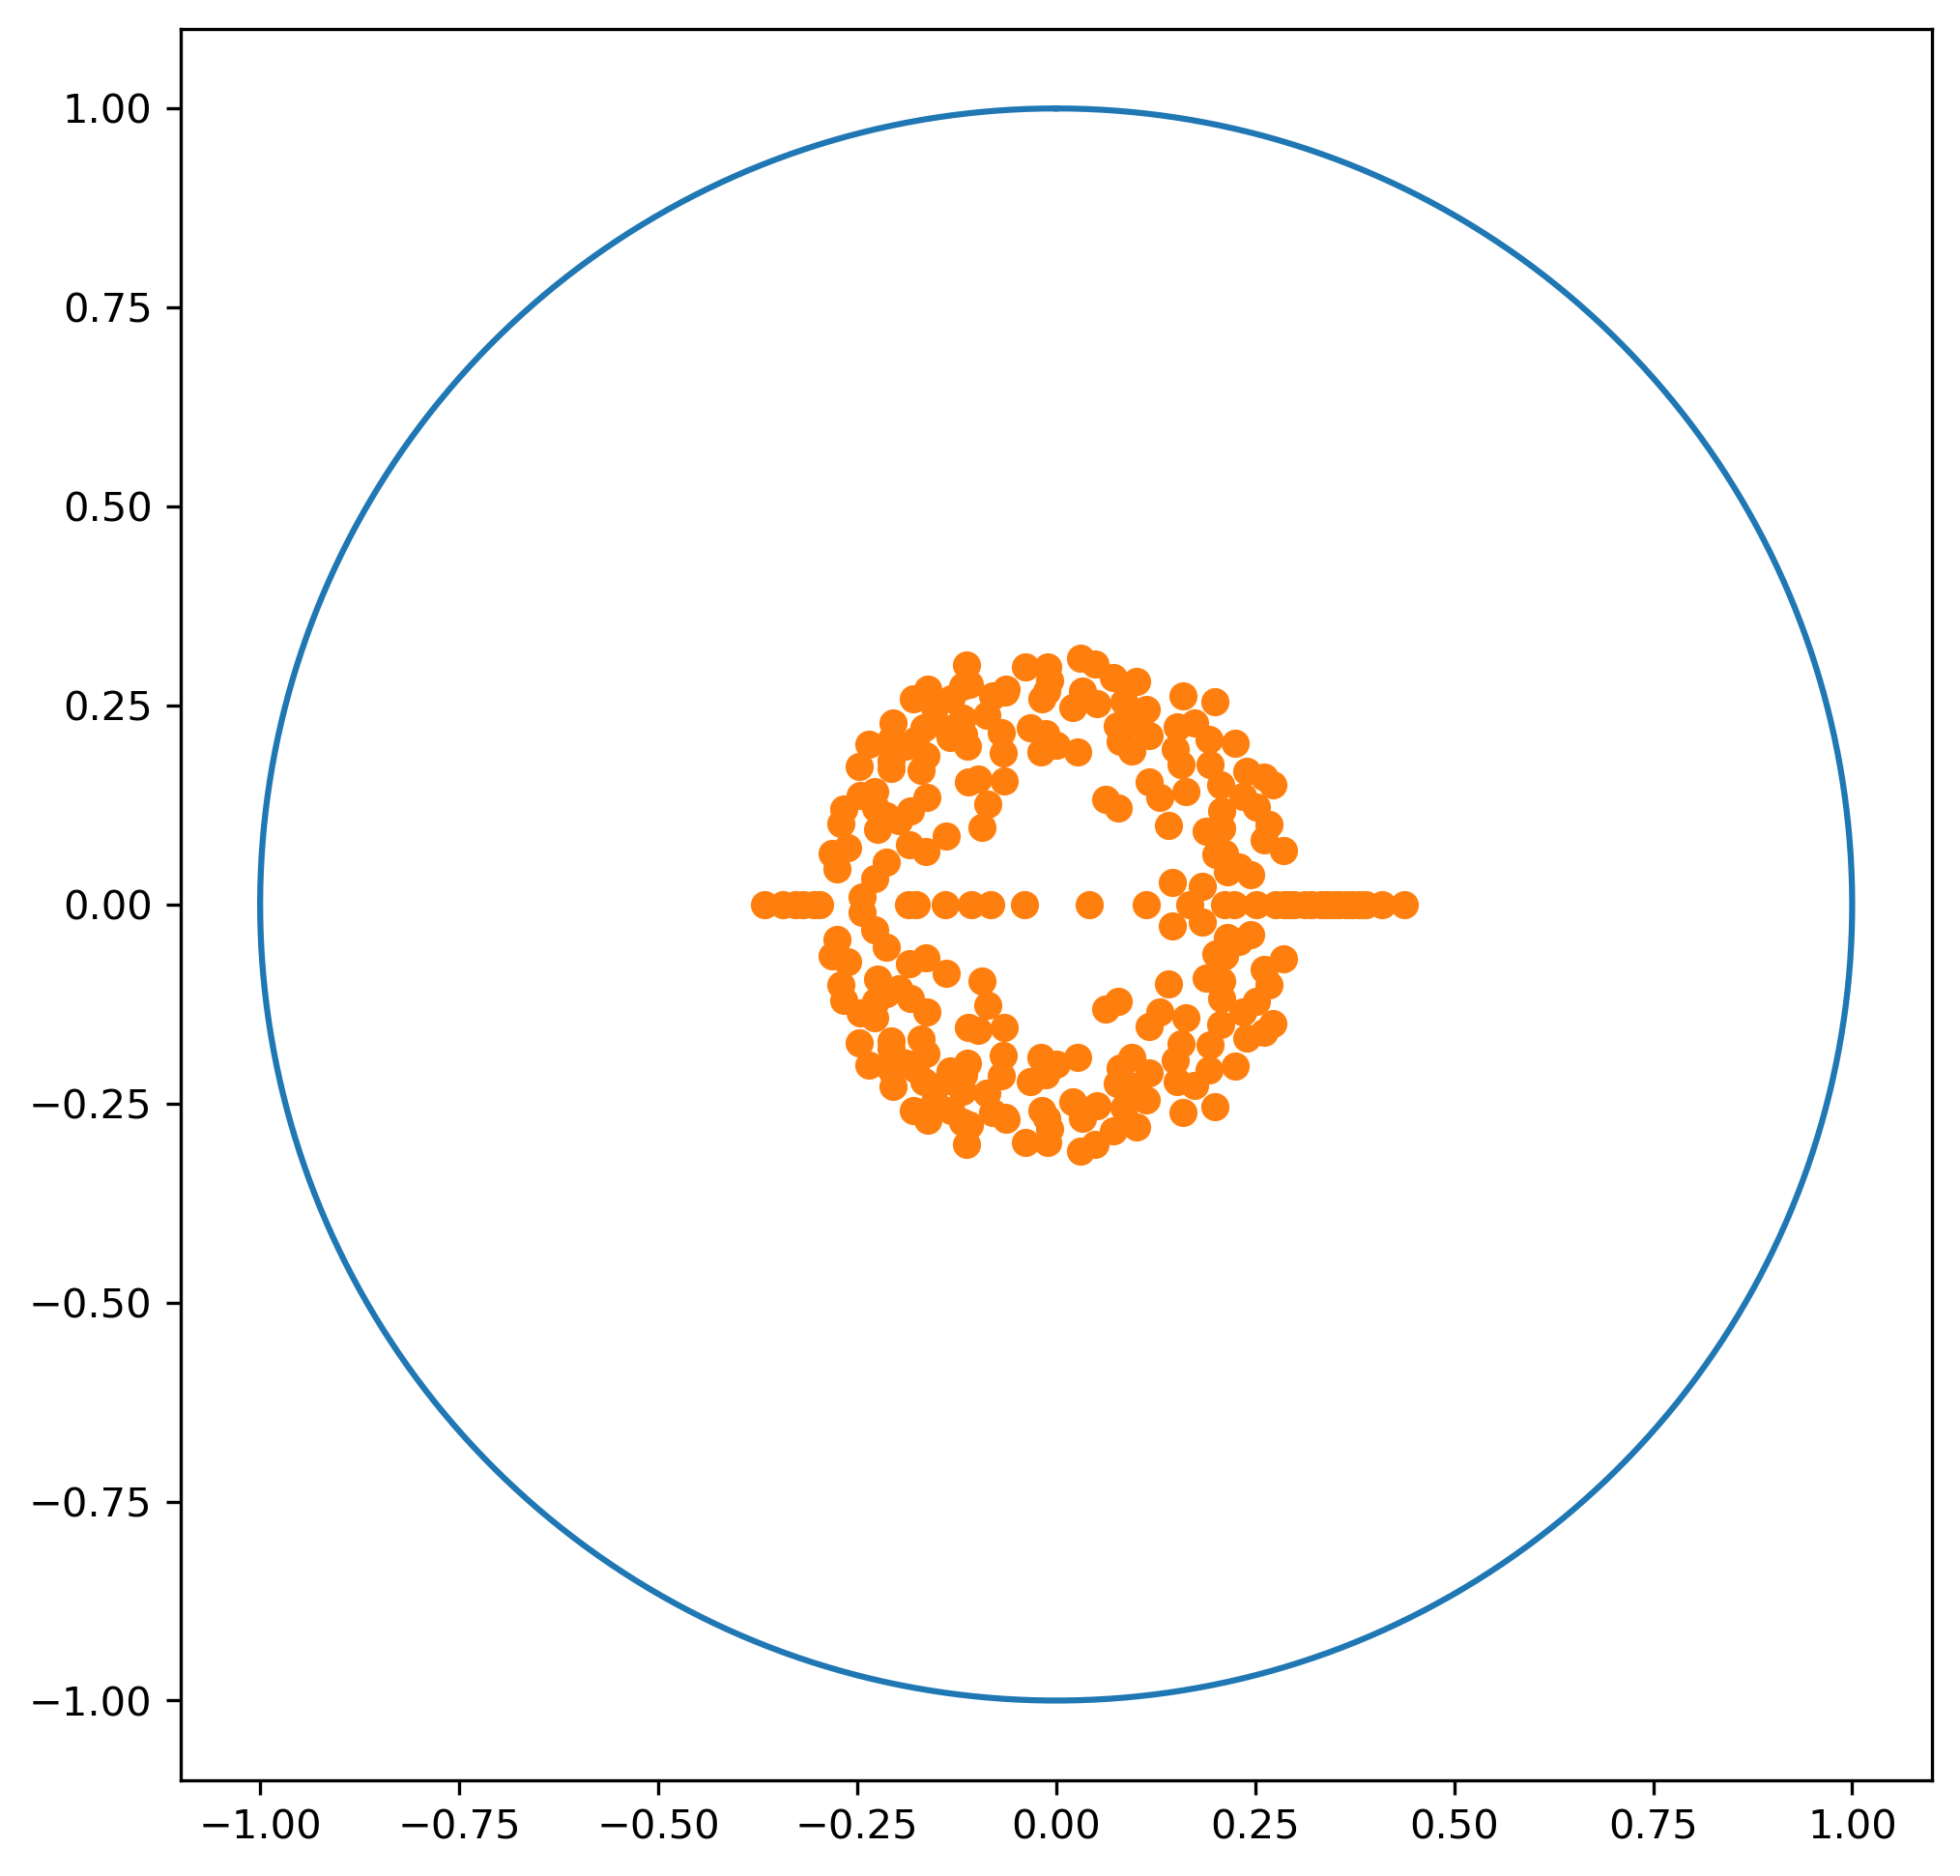

In [26]:
t = np.linspace(0, 2*np.pi, 1000)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(*spectrum, "o")
plt.show()